In [353]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
from scipy.stats import genextreme as gev
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram

from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv


extRemes = importr("extRemes")

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [354]:

twosamples = importr("twosamples")

In [355]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [356]:
import warnings
warnings.filterwarnings('ignore')

In [357]:
from scipy.stats import genextreme as gev
def empirical_return_level(data):
    """
    Compute empirical return level using the algorithm introduced in Tutorial 2
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranks_sp"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranks_sp"] / (n + 1)
    # find return period
    df["period"] = 1 / df["exceedance"]

    df = df[::-1]

    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )
    return out

In [358]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [359]:
yearb=1941
yeare=2025

ifile='/Projects/RAPrototype/ERA5/AnnualMaximumDailyTmax.era5.1941.2025.nc4'

dso = xr.open_dataset(ifile)
dso = dso.sel(time=slice(f'{yearb}-01-01',f'{yeare}-02-01'))
dso = dso.sortby('lat')
dso['time'] = np.arange(yearb,yeare+1,1)

return_periods = [2, 5, 10, 25, 50, 100]
Tlon = dso.lon.data
Tlat = dso.lat.data
dso = dso.drop_vars('TXx_day')
units = 'K'

dso['TXx'] = (dso['TXx'] - 273.15) * 9/5 + 32 

units = f'$\degree$ F'
ds = dso

In [360]:
ptlon=[260,270,264.25,241,205,204,289]
ptlat=[48,40,37,46.25,68.75,60,45]

In [361]:
c=[1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000]
ksN=9999
year=np.arange(yearb,yeare,1)

# create vector of years
years = np.arange(1.1, 100, 0.1)

Text(0.5, 0.98, 'TXx mean (1941-2025)')

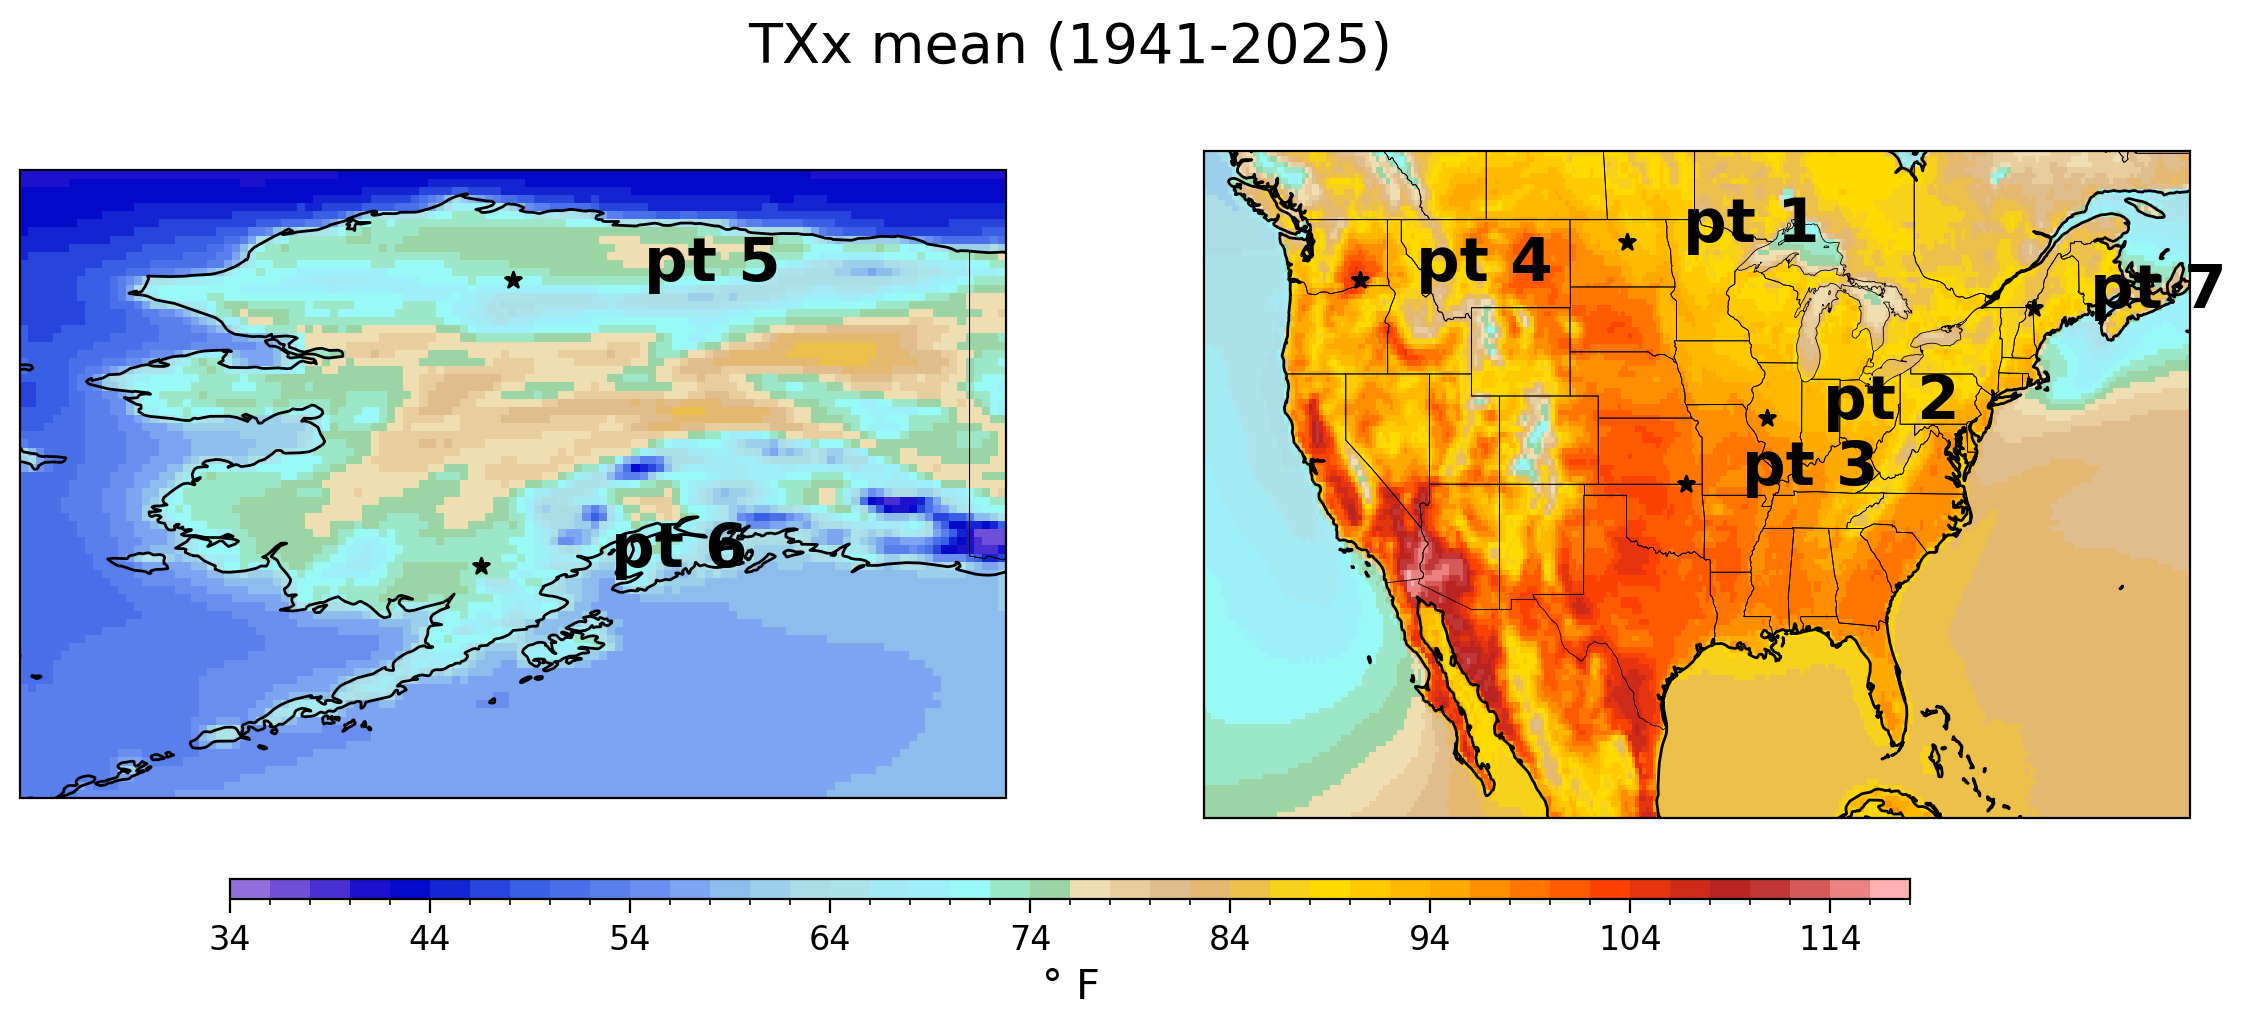

In [362]:
cmap=cmaps.amwg256
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

cc=ds['TXx'].mean('time').sel(lon=slice(190,220),lat=slice(53,72)).plot(ax=ax[0],cmap=cmap,levels=np.arange(34,120,2),add_colorbar=False)
for ip in range(4,6):
  ax[0].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[0].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
ax[0].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.3) 
ax[0].coastlines()


cc=ds['TXx'].mean('time').sel(lon=slice(230,300),lat=slice(22,52)).plot(ax=ax[1],cmap=cmap,levels=np.arange(34,120,2),add_colorbar=False)
for ip in range(0,4):
  ax[1].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[1].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
ax[1].scatter(ptlon[6],ptlat[6],marker='*',color='k')
ax[1].text(ptlon[6]-360+4,ptlat[6],f'pt {6+1}',color='k',size=22,weight='bold')
ax[1].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.3) 
ax[1].coastlines()
ax_cbar = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label=units)
cbar.ax.tick_params(labelsize=12)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)
plt.suptitle(f'TXx mean ({yearb}-{yeare})', fontsize=20)

In [363]:
CB_color = ['#377eb8', '#ff7f00', '#4daf4a',
            '#e41a1c', '#a65628', '#984ea3',
            '#999999', '#f781bf', '#dede00']

# Pt 1

In [364]:
ij=0
ilon=ptlon[ij]
ilat=ptlat[ij]
txx=ds['TXx'].sel(lon=ilon,lat=ilat).load()

In [365]:

df = txx.to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      TXx              year     
 Min.   : 86.36   Min.   :1941  
 1st Qu.: 90.98   1st Qu.:1962  
 Median : 92.47   Median :1983  
 Mean   : 93.21   Mean   :1983  
 3rd Qu.: 95.64   3rd Qu.:2004  
 Max.   :102.66   Max.   :2025  



Define fit for GEV, Gumbel, Frechet, Weibull

#################
GEV
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  223.4191 


 Estimated parameters:
  location      scale      shape 
91.8757682  3.1799074 -0.1895238 

 Standard Error Estimates:
  location      scale      shape 
0.38363013 0.27086173 0.07324416 

 Estimated parameter covariance matrix.
            location        scale        shape
location  0.14717208  0.015922396 -0.010682674
scale     0.01592240  0.073366075 -0.009882939
shape    -0.01068267 -0.009882939  0.005364707

 AIC = 452.8381 

 BIC = 460.1661 


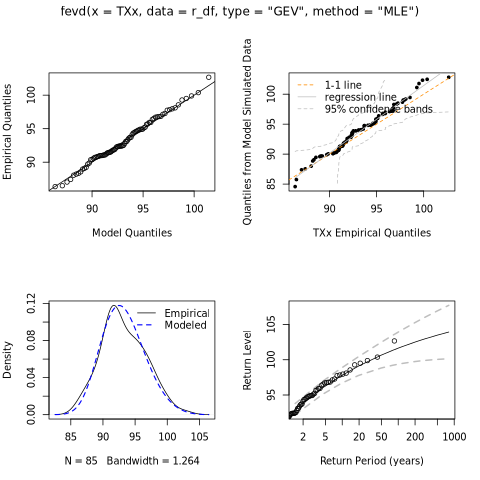

In [366]:
%R fitGEV <- fevd(TXx, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(TXx, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = TXx, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  225.9241 


 Estimated parameters:
 location     scale 
91.561518  3.064067 

 Standard Error Estimates:
 location     scale 
0.3517192 0.2492829 

 Estimated parameter covariance matrix.
           location      scale
location 0.12370638 0.02869722
scale    0.02869722 0.06214197

 AIC = 455.8481 

 BIC = 460.7334 


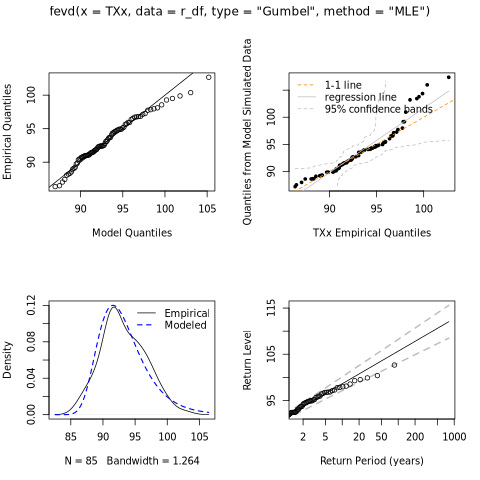

In [367]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

Extract return_periods

In [368]:
%R return_periods <- c( 1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
#%R rlWei<-return.level(fitWei, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

Example to show that
- stats.truncnorm needs to specify first guess to give a sensible result, didn't find an optimizer working.
- stats.genextreme : using optimize option or giving first guess give the same result
- stats.genextreme fc=0 (Gumbel): optimize option, giving first guess or nothing give the same result 

Text(0.5, 1.0, 'PT 1 (260$\\degree$E; 48$\\degree$N)')

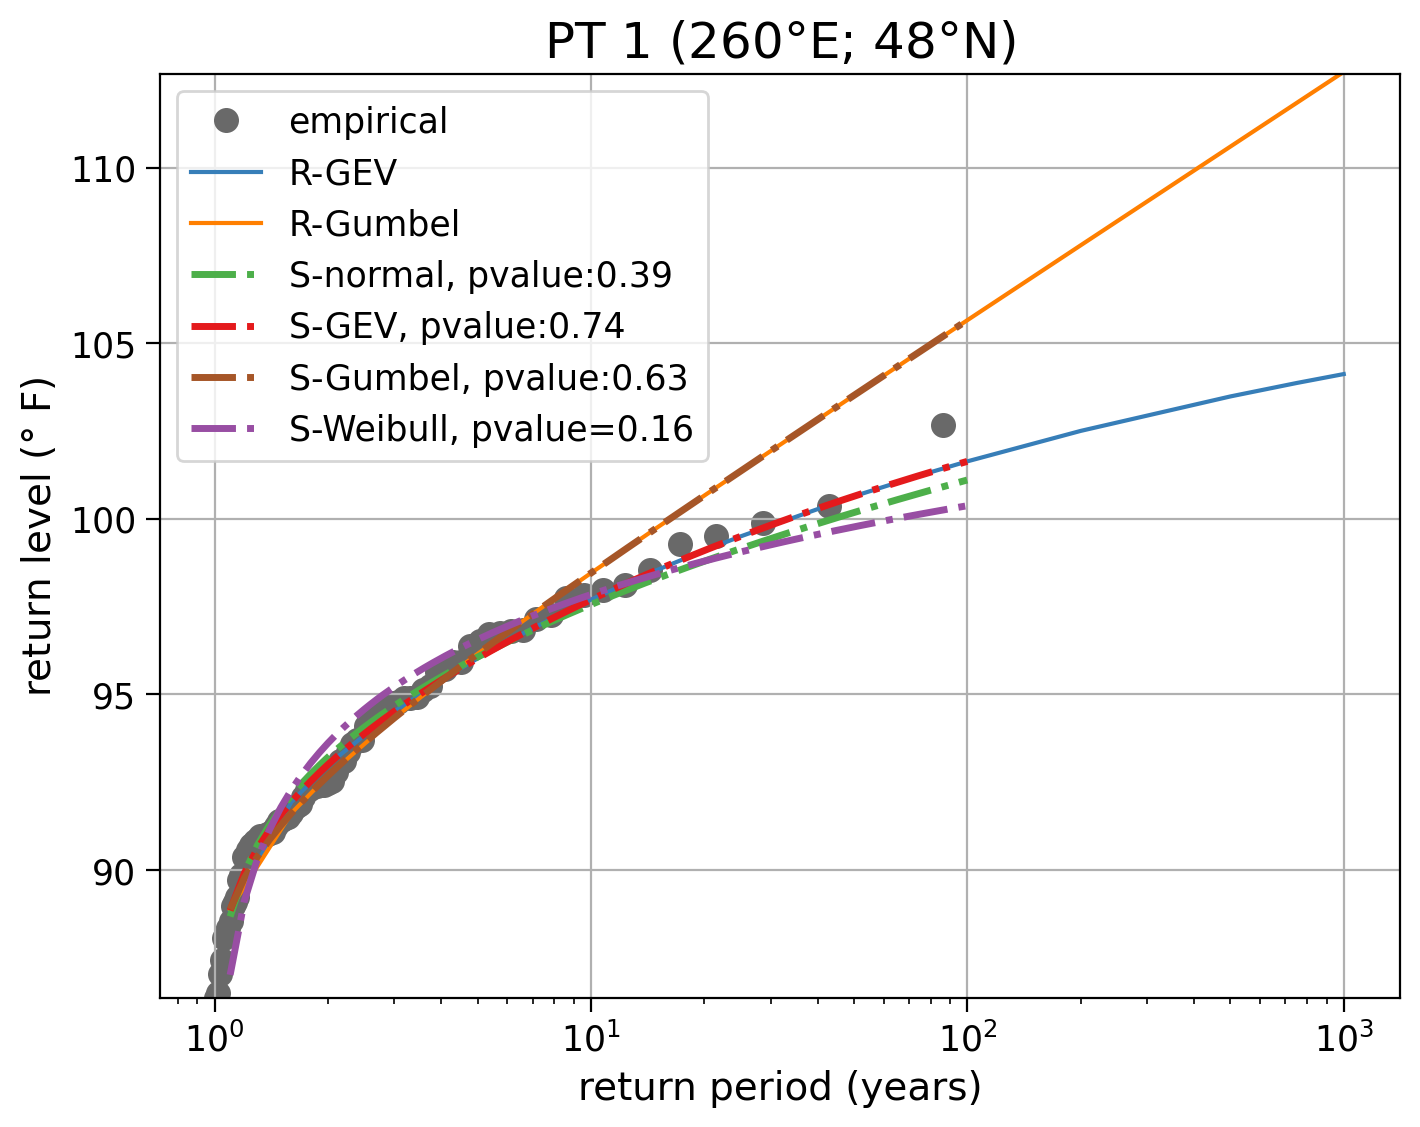

In [369]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(txx).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(txx,stats.norm.cdf, \
     args=(txx.mean(),txx.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=txx.mean(), scale=txx.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(txx,fc=0,loc=txx.mean(), scale=txx.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(txx, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(txx, floc=0, loc=txx.mean(), scale=txx.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(txx, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(txx.min(),txx.max()+10.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

For point1, R-GEV, S-GEV optimized and S-Gumbel give the same result.

Text(0.5, 1.0, 'PT 1 (260$\\degree$E;48$\\degree$N)')

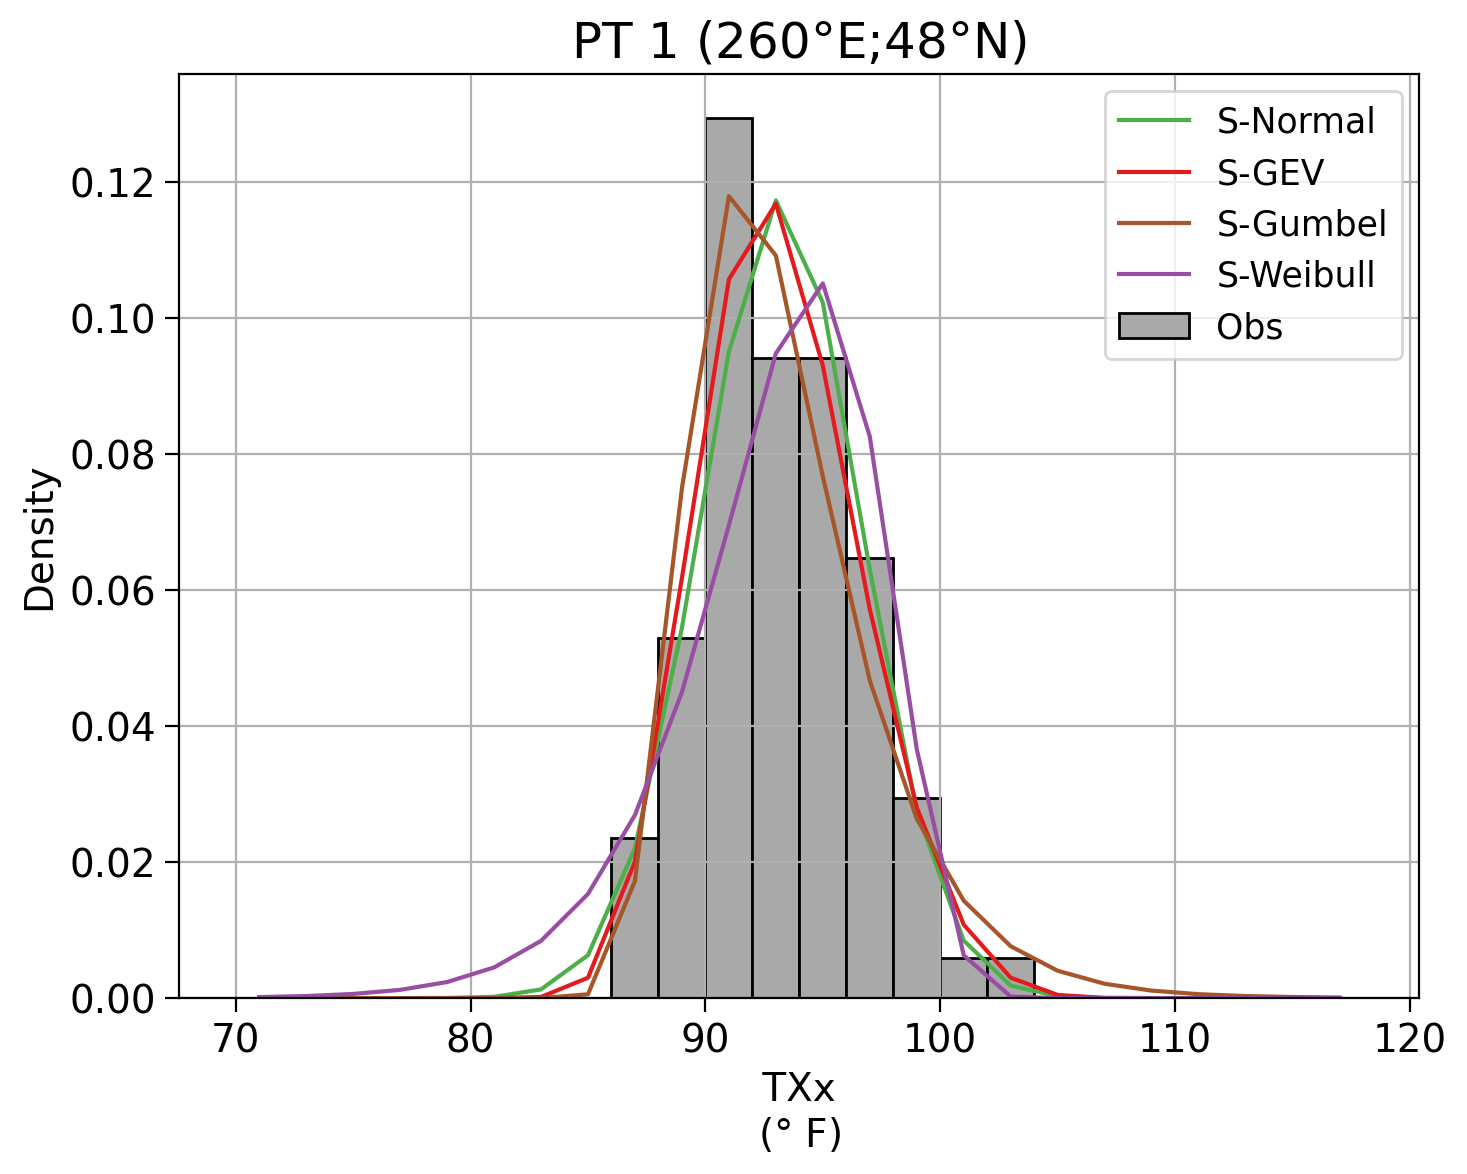

In [370]:
####
##### PDF Plot
#####

bins = np.arange(70,120,2)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(txx, bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=txx.mean(), scale=txx.std()),
    c=CB_color[2],lw=1.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=1.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=1.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=1.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(txx,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" TXx \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

In [371]:
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
print(f"S-GEV, pvalue:{pv_g}")

S-GEV, pvalue:0.74


In [372]:
stats.cramervonmises(txx, 'genextreme', args=pgev)

CramerVonMisesResult(statistic=0.05209985707820422, pvalue=0.8647053939470367)

Only Scipy functions.

# Pt 2

In [373]:
ij=1
ilon=ptlon[ij]
ilat=ptlat[ij]
txx=ds['TXx'].sel(lon=ilon,lat=ilat).load()

df = txx.to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      TXx              year     
 Min.   : 91.59   Min.   :1941  
 1st Qu.: 93.71   1st Qu.:1962  
 Median : 95.33   Median :1983  
 Mean   : 95.83   Mean   :1983  
 3rd Qu.: 97.29   3rd Qu.:2004  
 Max.   :107.02   Max.   :2025  



#################
GEV
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  198.2438 


 Estimated parameters:
   location       scale       shape 
94.56742557  2.09580963  0.02206336 

 Standard Error Estimates:
 location     scale     shape 
0.2613119 0.1952055 0.0913212 

 Estimated parameter covariance matrix.
             location        scale        shape
location  0.068283935  0.022358968 -0.009388624
scale     0.022358968  0.038105170 -0.006227144
shape    -0.009388624 -0.006227144  0.008339561

 AIC = 402.4875 

 BIC = 409.8155 


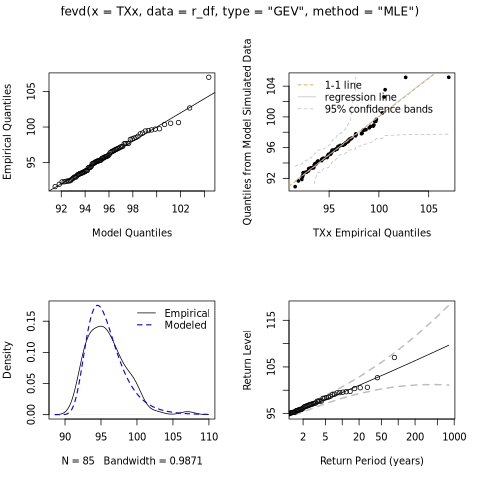

In [374]:
%R fitGEV <- fevd(TXx, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(TXx, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = TXx, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  198.2744 


 Estimated parameters:
 location     scale 
94.592852  2.114003 

 Standard Error Estimates:
 location     scale 
0.2414737 0.1820355 

 Estimated parameter covariance matrix.
           location      scale
location 0.05830957 0.01378317
scale    0.01378317 0.03313691

 AIC = 400.5487 

 BIC = 405.434 


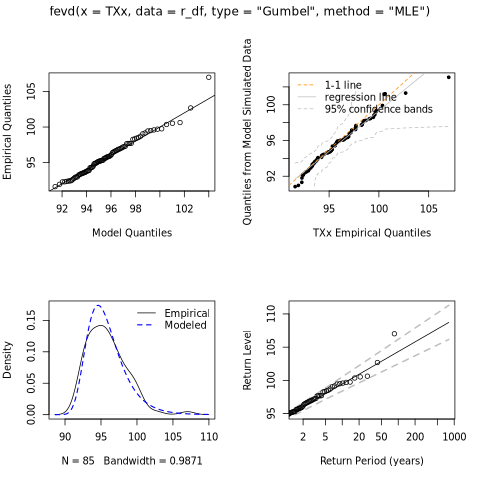

In [375]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [376]:
%R return_periods <- c( 1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

Text(0.5, 1.0, 'PT 2 (270$\\degree$E; 40$\\degree$N)')

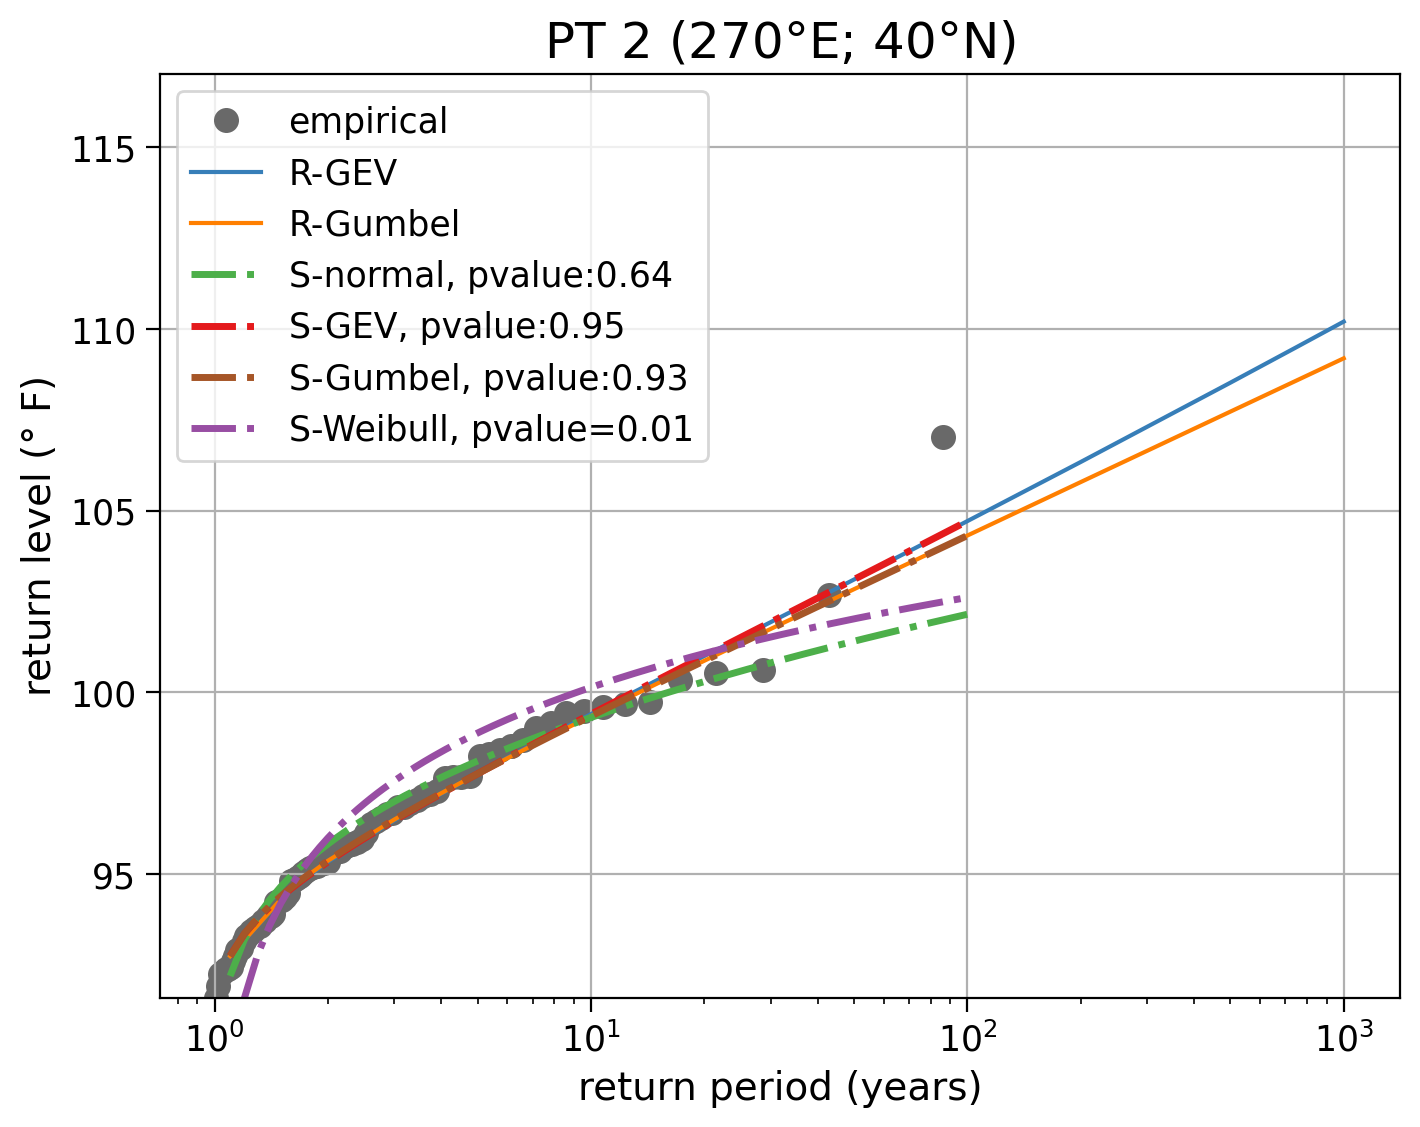

In [377]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(txx).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(txx,stats.norm.cdf, \
     args=(txx.mean(),txx.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=txx.mean(), scale=txx.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(txx,fc=0,loc=txx.mean(), scale=txx.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(txx, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(txx, floc=0, loc=txx.mean(), scale=txx.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(txx, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(txx.min(),txx.max()+10.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 2 (270$\\degree$E;40$\\degree$N)')

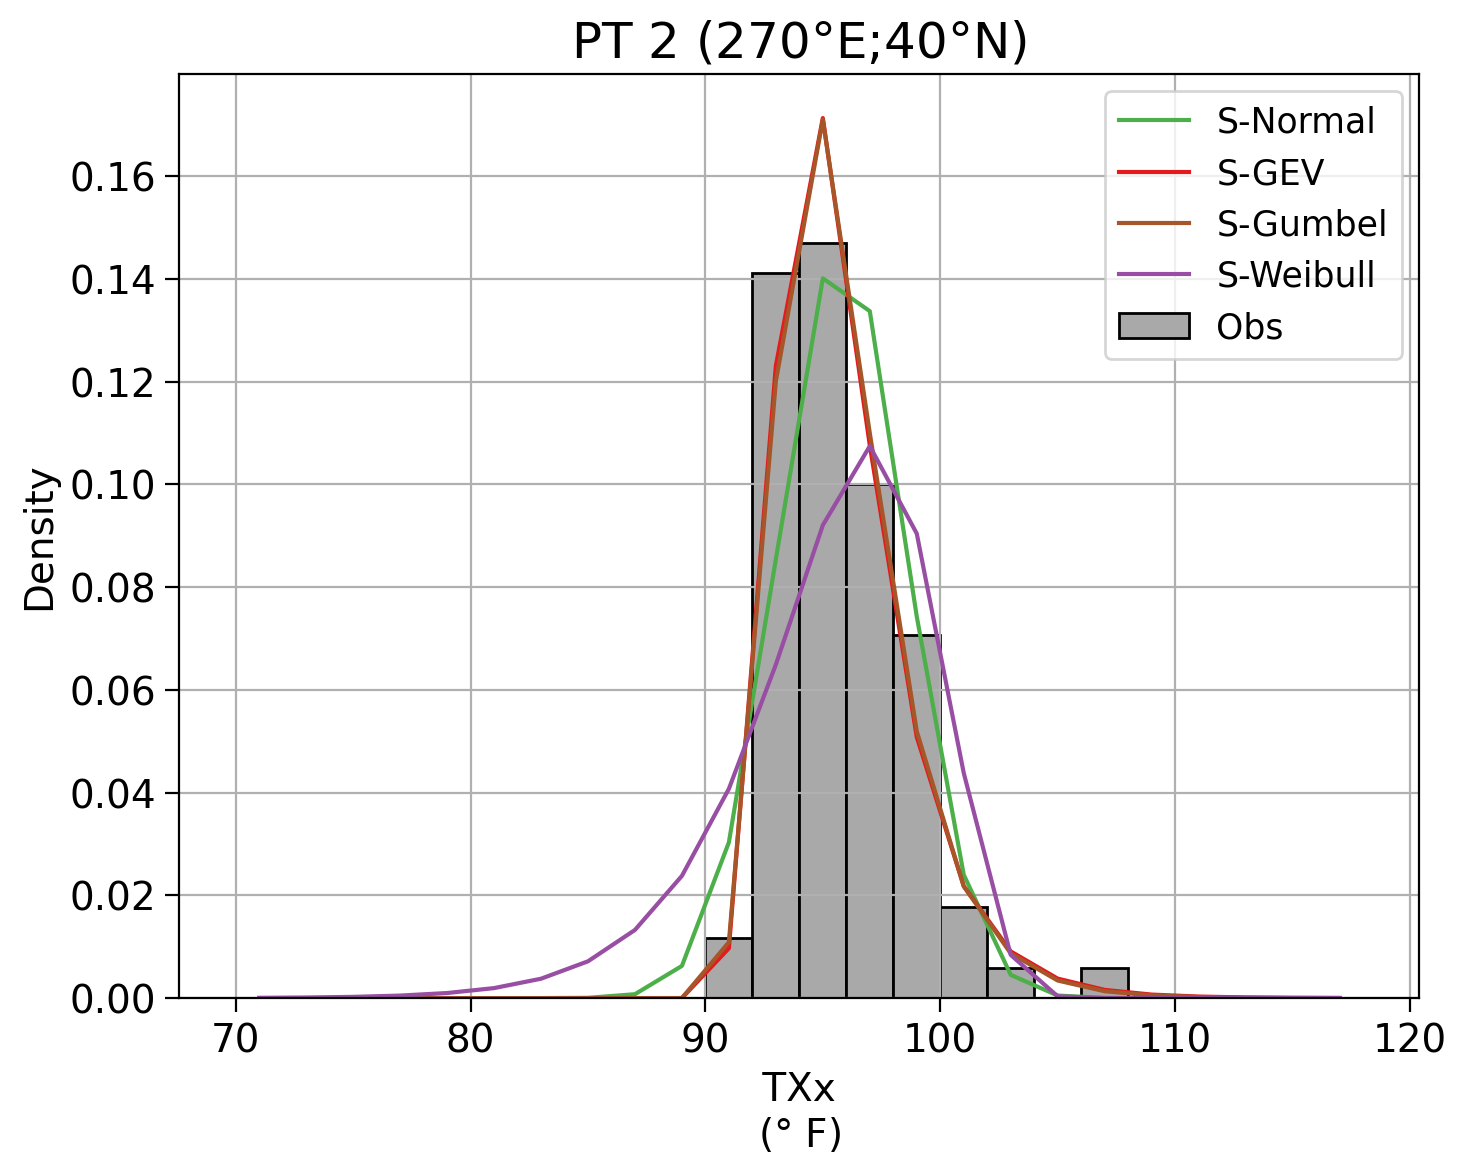

In [378]:
####
##### PDF Plot
#####

bins = np.arange(70,120,2)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(txx, bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=txx.mean(), scale=txx.std()),
    c=CB_color[2],lw=1.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=1.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=1.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=1.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(txx,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" TXx \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 3

In [379]:
ij=2
ilon=ptlon[ij]
ilat=ptlat[ij]
txx=ds['TXx'].sel(lon=ilon,lat=ilat).load()

df = txx.to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      TXx              year     
 Min.   : 93.59   Min.   :1941  
 1st Qu.: 97.38   1st Qu.:1962  
 Median : 99.13   Median :1983  
 Mean   : 99.55   Mean   :1983  
 3rd Qu.:101.18   3rd Qu.:2004  
 Max.   :111.27   Max.   :2025  



#################
GEV
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  214.2465 


 Estimated parameters:
   location       scale       shape 
98.14880478  2.64001544 -0.04613805 

 Standard Error Estimates:
  location      scale      shape 
0.31915695 0.22684570 0.07238511 

 Estimated parameter covariance matrix.


             location       scale        shape
location  0.101861161  0.02310474 -0.007932779
scale     0.023104739  0.05145897 -0.005154890
shape    -0.007932779 -0.00515489  0.005239604

 AIC = 434.4929 

 BIC = 441.8209 


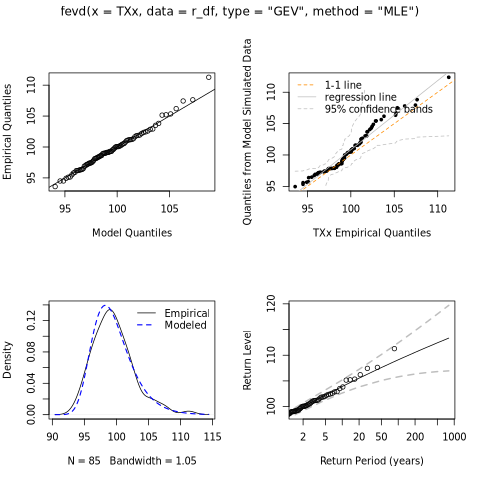

In [380]:
%R fitGEV <- fevd(TXx, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(TXx, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = TXx, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  214.4321 


 Estimated parameters:
location    scale 
98.08234  2.60772 

 Standard Error Estimates:
 location     scale 
0.2983096 0.2175478 

 Estimated parameter covariance matrix.
           location      scale
location 0.08898861 0.02062257
scale    0.02062257 0.04732705

 AIC = 432.8642 

 BIC = 437.7495 


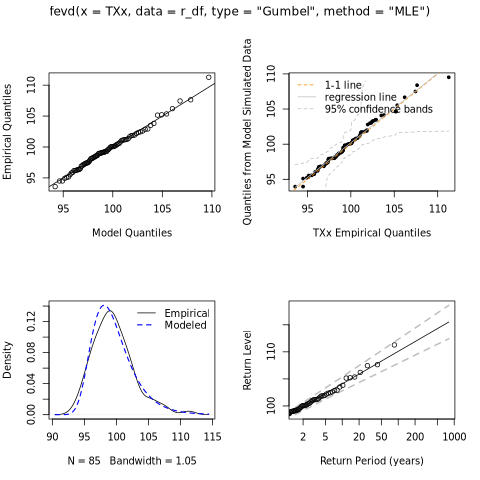

In [381]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [382]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb



Text(0.5, 1.0, 'PT 3 (264.25$\\degree$E; 37$\\degree$N)')

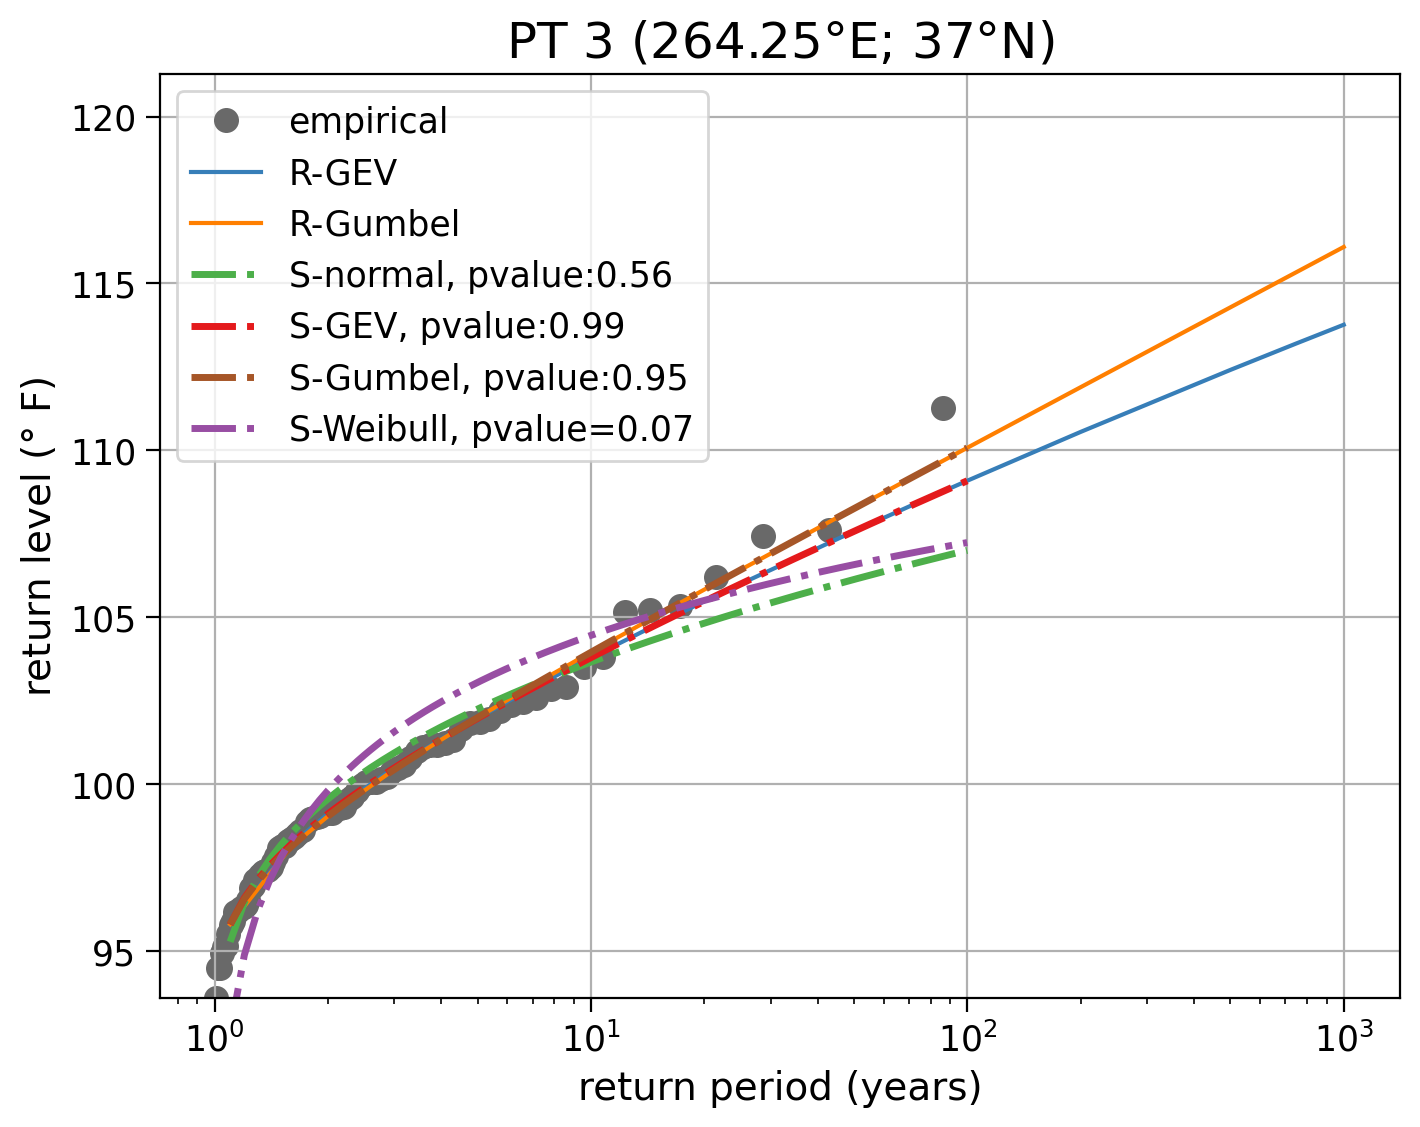

In [383]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(txx).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(txx,stats.norm.cdf, \
     args=(txx.mean(),txx.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=txx.mean(), scale=txx.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(txx,fc=0,loc=txx.mean(), scale=txx.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(txx, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(txx, floc=0, loc=txx.mean(), scale=txx.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(txx, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(txx.min(),txx.max()+10.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 3 (264.25$\\degree$E;37$\\degree$N)')

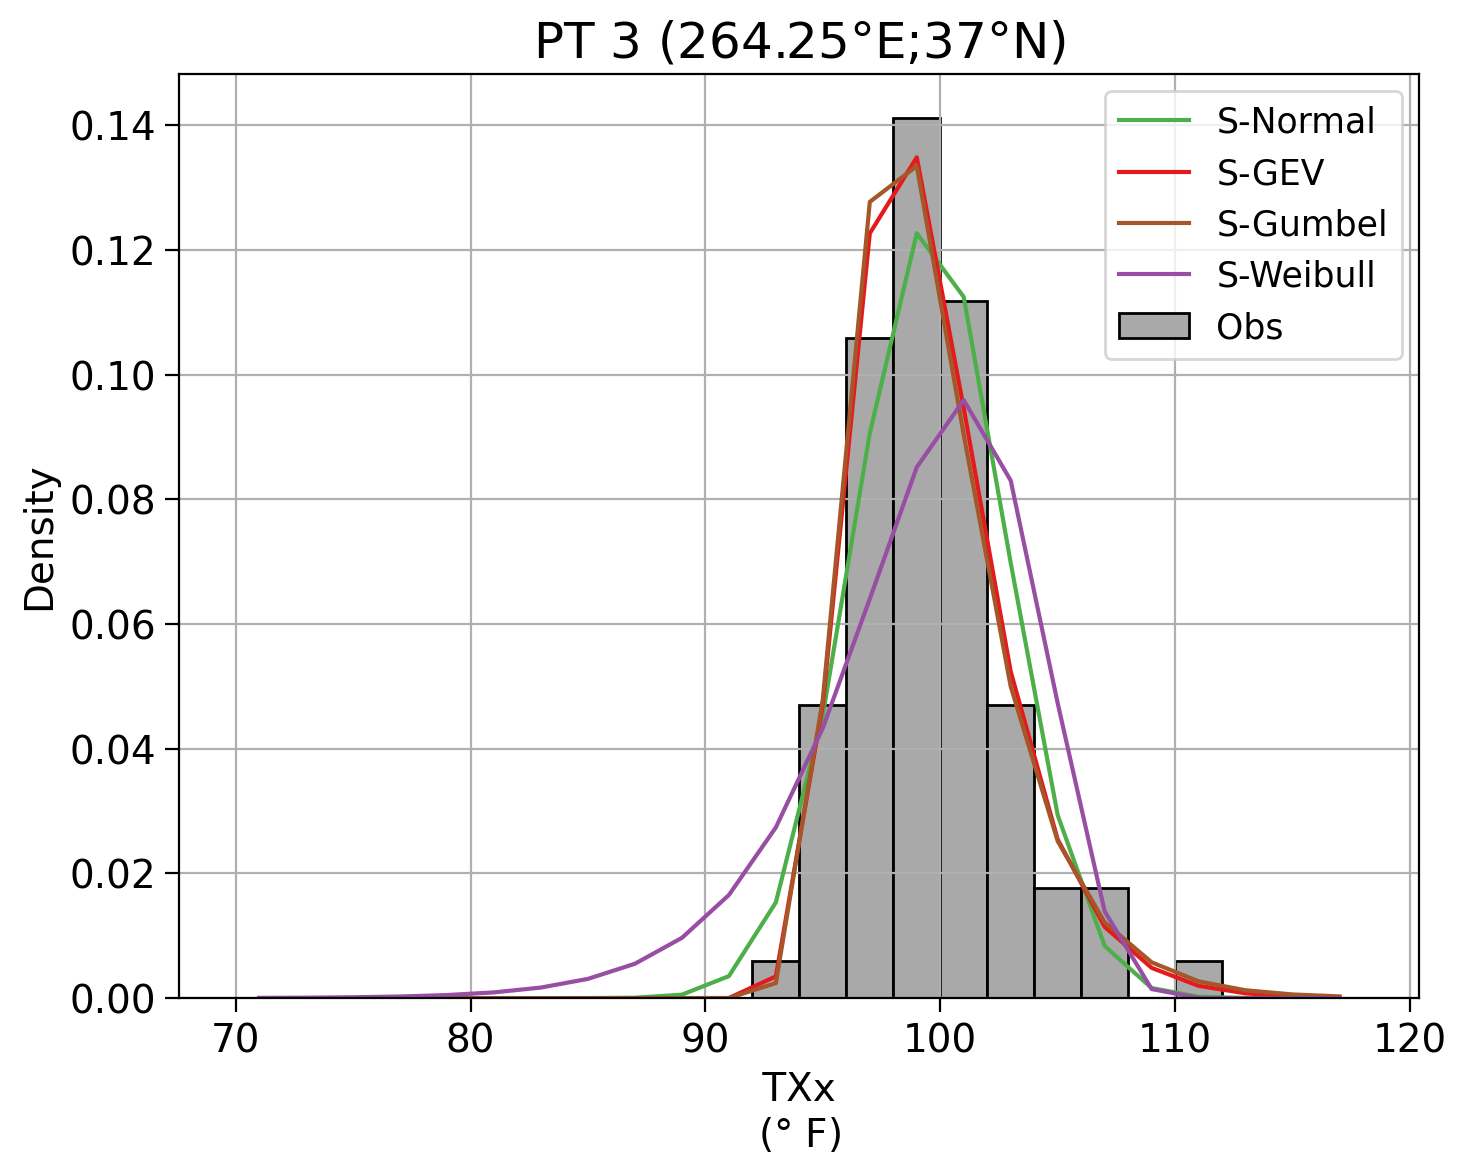

In [384]:
####
##### PDF Plot
#####

bins = np.arange(70,120,2)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(txx, bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=txx.mean(), scale=txx.std()),
    c=CB_color[2],lw=1.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=1.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=1.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=1.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(txx,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" TXx \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 4

In [385]:
ij=3
ilon=ptlon[ij]
ilat=ptlat[ij]
txx=ds['TXx'].sel(lon=ilon,lat=ilat).load()

df = txx.to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      TXx              year     
 Min.   : 98.09   Min.   :1941  
 1st Qu.:102.49   1st Qu.:1962  
 Median :104.10   Median :1983  
 Mean   :104.61   Mean   :1983  
 3rd Qu.:107.16   3rd Qu.:2004  
 Max.   :116.63   Max.   :2025  



#################
GEV
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  227.1857 


 Estimated parameters:
    location        scale        shape 
103.03351238   3.12879512  -0.07865177 

 Standard Error Estimates:
  location      scale      shape 
0.37841233 0.26749088 0.07296412 

 Estimated parameter covariance matrix.
             location        scale        shape
location  0.143195892  0.028675712 -0.009797369
scale     0.028675712  0.071551372 -0.007023087
shape    -0.009797369 -0.007023087  0.005323763

 AIC = 460.3715 

 BIC = 467.6994 


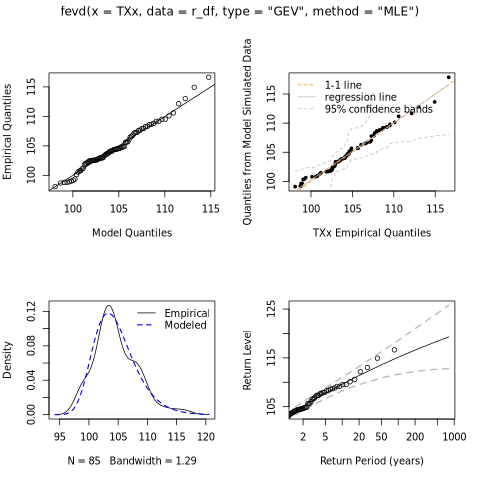

In [386]:
%R fitGEV <- fevd(TXx, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(TXx, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = TXx, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  227.6903 


 Estimated parameters:
  location      scale 
102.901901   3.068088 

 Standard Error Estimates:
 location     scale 
0.3513119 0.2545327 

 Estimated parameter covariance matrix.
           location      scale
location 0.12342007 0.02865841
scale    0.02865841 0.06478689

 AIC = 459.3806 

 BIC = 464.2659 


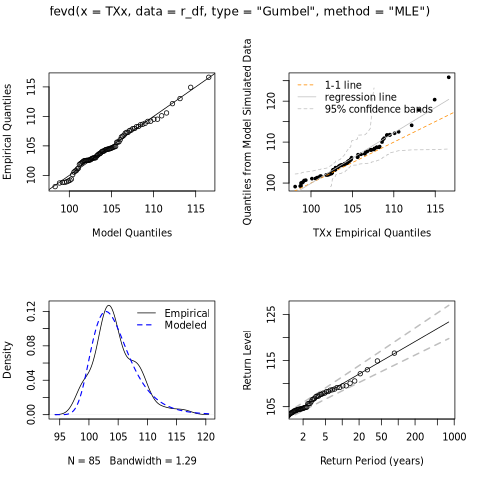

In [387]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [388]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb



Text(0.5, 1.0, 'PT 4 (241$\\degree$E; 46.25$\\degree$N)')

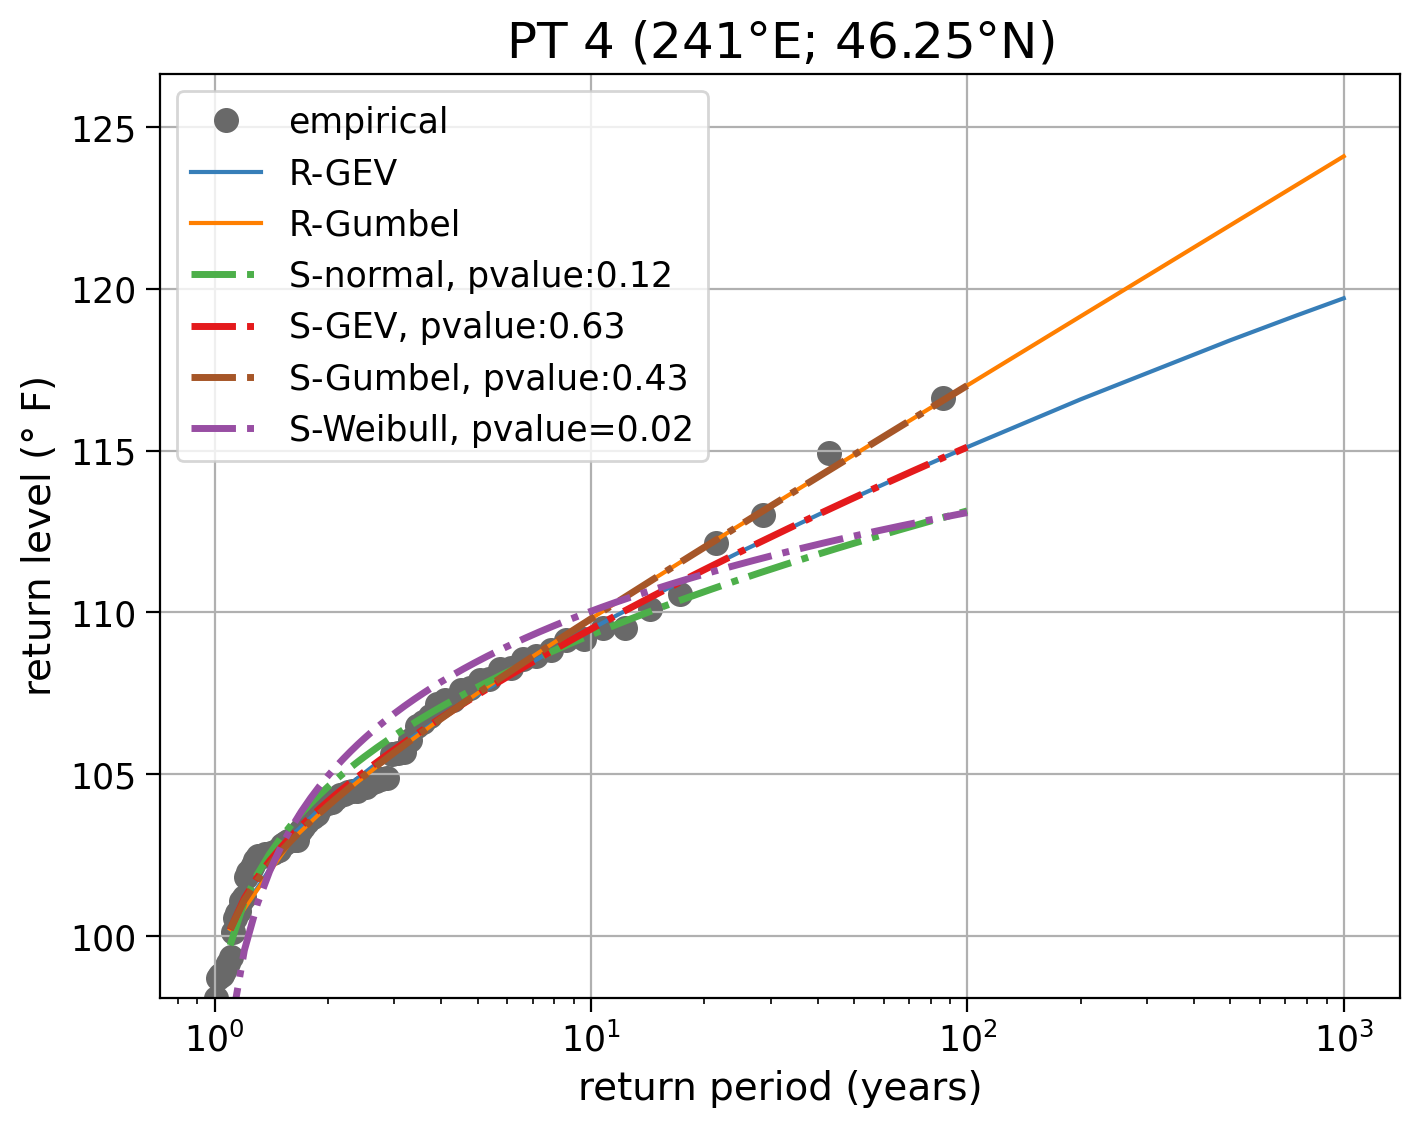

In [389]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(txx).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(txx,stats.norm.cdf, \
     args=(txx.mean(),txx.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=txx.mean(), scale=txx.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(txx,fc=0,loc=txx.mean(), scale=txx.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(txx, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(txx, floc=0, loc=txx.mean(), scale=txx.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(txx, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(txx.min(),txx.max()+10.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 4 (241$\\degree$E;46.25$\\degree$N)')

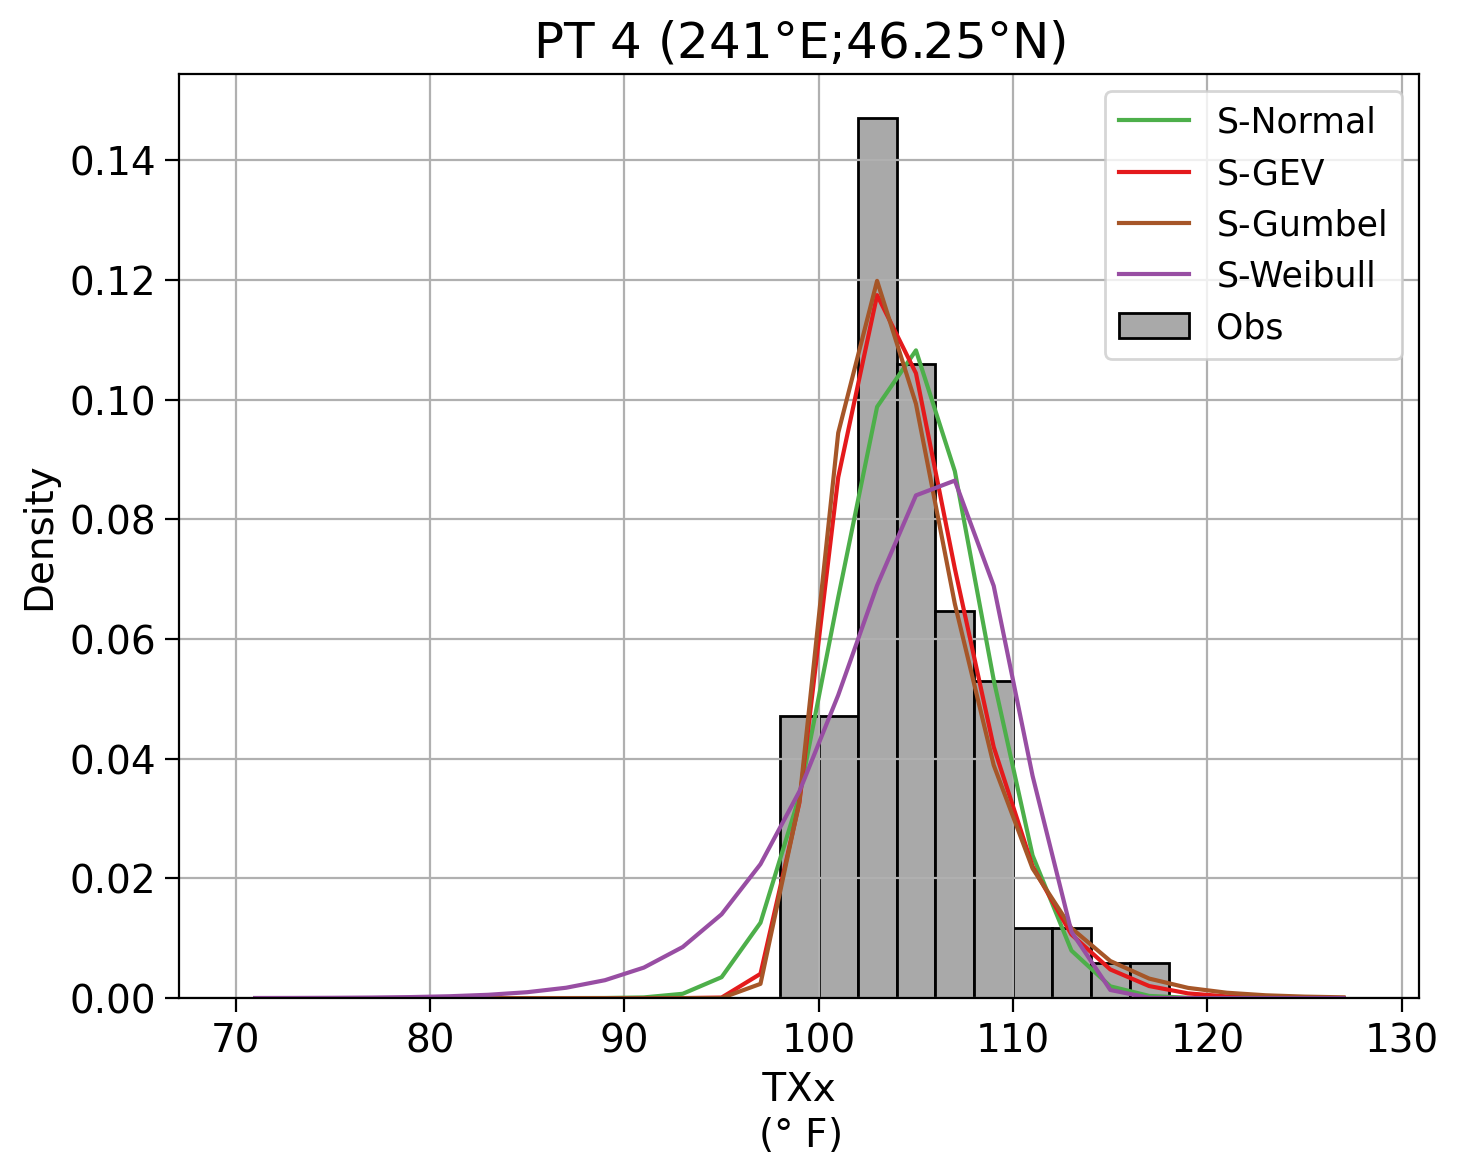

In [390]:
####
##### PDF Plot
#####

bins = np.arange(70,130,2)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(txx, bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=txx.mean(), scale=txx.std()),
    c=CB_color[2],lw=1.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=1.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=1.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=1.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(txx,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" TXx \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 5

In [391]:
ij=4
ilon=ptlon[ij]
ilat=ptlat[ij]
txx=ds['TXx'].sel(lon=ilon,lat=ilat).load()

df = txx.to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      TXx             year     
 Min.   :63.39   Min.   :1941  
 1st Qu.:68.56   1st Qu.:1962  
 Median :71.88   Median :1983  
 Mean   :71.69   Mean   :1983  
 3rd Qu.:74.35   3rd Qu.:2004  
 Max.   :80.00   Max.   :2025  



In [392]:
%R fitGEV <- fevd(TXx, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(TXx, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R -o locGEV,scaleGEV,shapeGEV

#################
GEV
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  234.5016 


 Estimated parameters:
  location      scale      shape 
70.4068884  3.8946263 -0.3251044 

 Standard Error Estimates:
  location      scale      shape 
0.47275297 0.34813265 0.08272361 

 Estimated parameter covariance matrix.
             location        scale        shape
location  0.223495371  0.003115723 -0.016431893
scale     0.003115723  0.121196339 -0.018241462
shape    -0.016431893 -0.018241462  0.006843195

 AIC = 475.0031 

 BIC = 482.3311 


#################
GEV + First Guess
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE", initial = initial_vals)

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  234.5016 


 Estimated parameters:
  location      scale      shape 
70.4069225  3.8946235 -0.3251048 

 Standard Error Estimates:
  location      scale      shape 
0.47275244 0.34812993 0.08272399 

 Estimated parameter covariance matrix.
             location        scale        shape
location  0.223494873  0.003117051 -0.016432193
scale     0.003117051  0.121194445 -0.018241218
shape    -0.016432193 -0.018241218  0.006843259

 AIC = 475.0031 

 BIC = 482.3311 


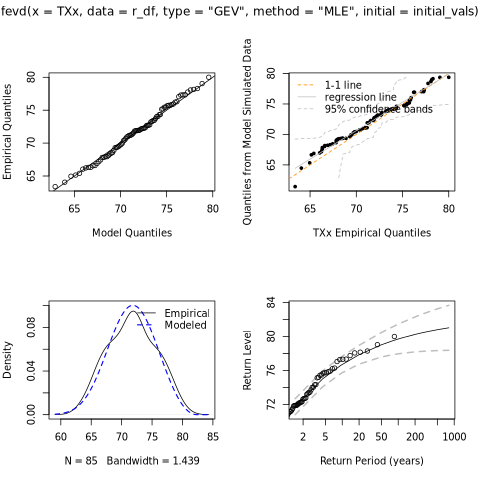

In [393]:
%R initial_vals <- list(location = mean(r_df[['TXx']]), scale = sd(r_df[['TXx']]), shape = 0.1)
%R fitGEV_FG <- fevd(TXx, data = r_df,type='GEV',method='MLE', initial = initial_vals)
%R fitGumb_FG <- fevd(TXx, data = r_df,type='Gumbel',method='MLE', initial = initial_vals) # Gumbel shape=0
print('#################')
print('GEV + First Guess')
print('#################')
%R pp <- summary(fitGEV_FG)
%R locGEV_FG <- pp[['par']][['location']]
%R scaleGEV_FG <- pp[['par']][['scale']]
%R shapeGEV_FG <- pp[['par']][['shape']]
%R plot(fitGEV_FG)
%R -o locGEV_FG,scaleGEV_FG,shapeGEV_FG

#################
Gumbel
#################

fevd(x = TXx, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  239.8033 


 Estimated parameters:
 location     scale 
69.764055  3.635068 

 Standard Error Estimates:
 location     scale 
0.4179182 0.2951932 

 Estimated parameter covariance matrix.
           location      scale
location 0.17465558 0.04090379
scale    0.04090379 0.08713900

 AIC = 483.6065 

 BIC = 488.4918 


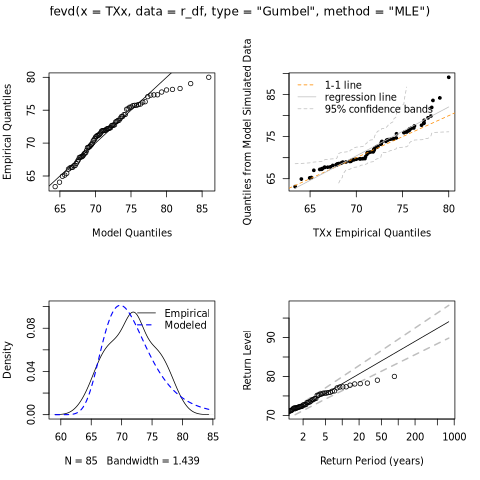

In [394]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [395]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGEV_FG<-return.level(fitGEV_FG, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGEV_FG,rlGumb


Text(0.5, 1.0, 'PT 5 (205$\\degree$E; 68.75$\\degree$N)')

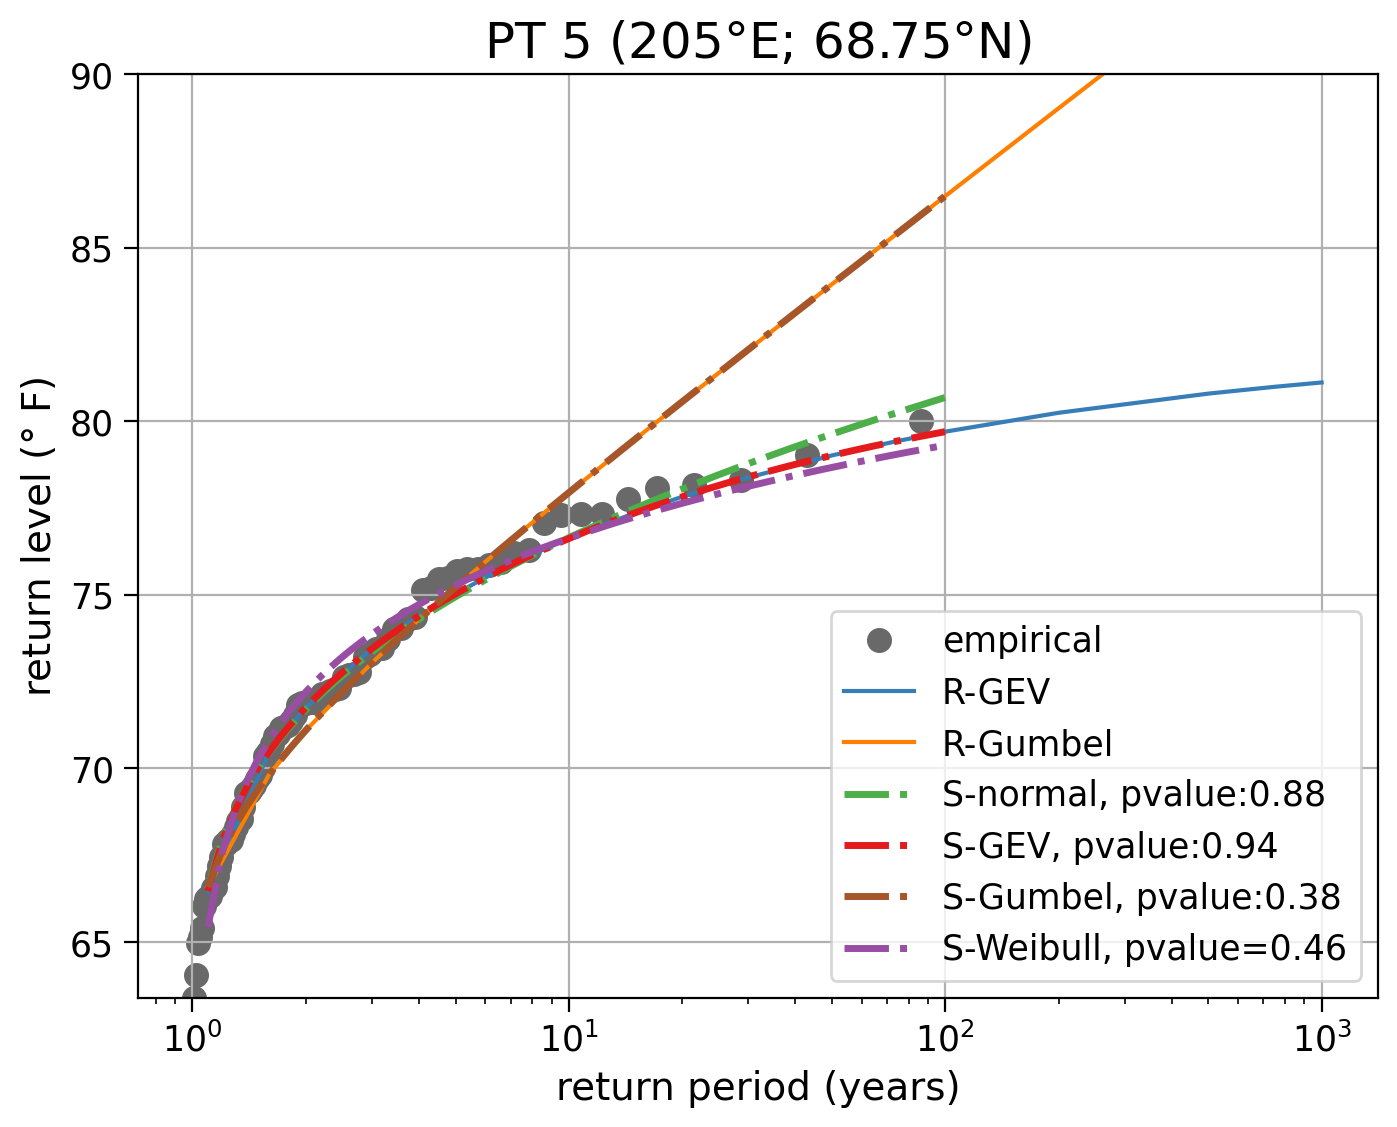

In [396]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(txx).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(txx,stats.norm.cdf, \
     args=(txx.mean(),txx.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=txx.mean(), scale=txx.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(txx,fc=0,loc=txx.mean(), scale=txx.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(txx, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(txx, floc=0, loc=txx.mean(), scale=txx.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(txx, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(txx.min(),txx.max()+10.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 5 (205$\\degree$E;68.75$\\degree$N)')

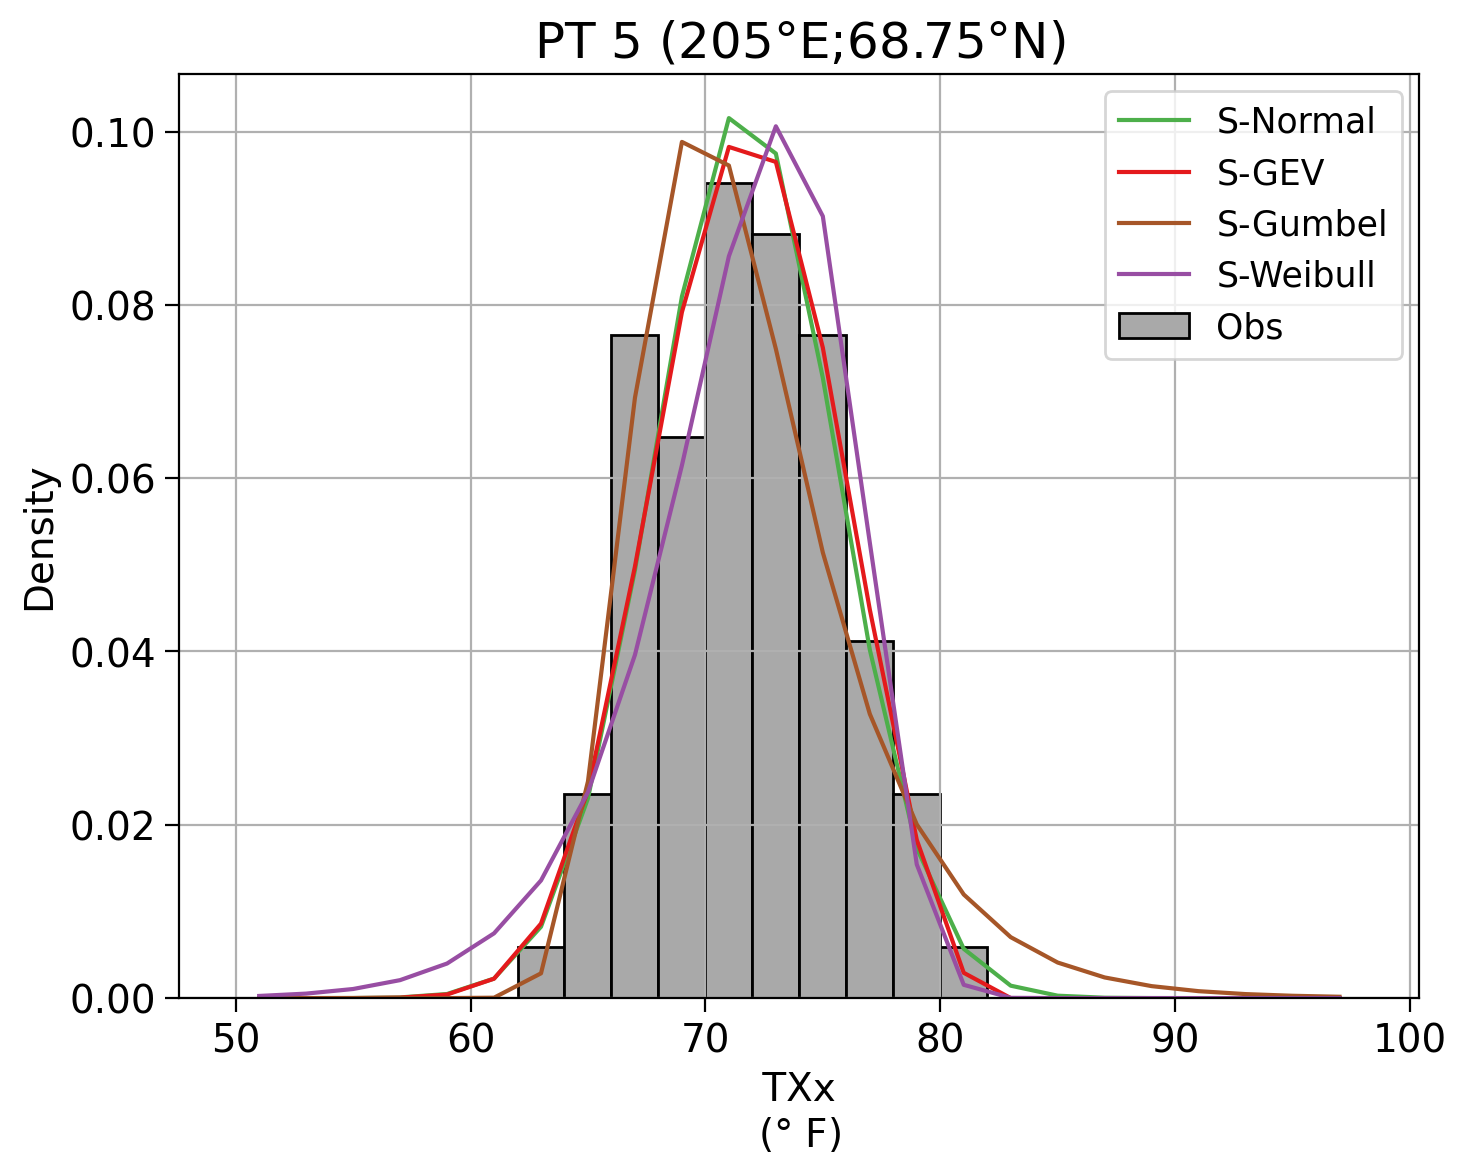

In [397]:
####
##### PDF Plot
#####

bins = np.arange(50,100,2)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(txx, bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=txx.mean(), scale=txx.std()),
    c=CB_color[2],lw=1.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=1.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=1.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=1.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(txx,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" TXx \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 6

In [398]:
ij=5
ilon=ptlon[ij]
ilat=ptlat[ij]
txx=ds['TXx'].sel(lon=ilon,lat=ilat).load()

df = txx.to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      TXx             year     
 Min.   :64.99   Min.   :1941  
 1st Qu.:70.41   1st Qu.:1962  
 Median :74.39   Median :1983  
 Mean   :73.72   Mean   :1983  
 3rd Qu.:76.69   3rd Qu.:2004  
 Max.   :88.23   Max.   :2025  



In [399]:
%R fitGEV <- fevd(TXx, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(TXx, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R -o locGEV,scaleGEV,shapeGEV

In addition: Warning messages:
1: In log(z) : NaNs produced
2: In log(z) : NaNs produced
3: In log(z) : NaNs produced
4: In log(z) : NaNs produced
5: In log(z) : NaNs produced
6: In log(z) : NaNs produced


#################
GEV
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  519.6858 


 Estimated parameters:
 location     scale     shape 
 68.92542 128.68293  32.73079 

 AIC = 1045.372 

 BIC = 1052.7 


#################
GEV + First Guess
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE", initial = initial_vals)

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  242.9175 


 Estimated parameters:
  location      scale 

     shape 
72.0190862  4.0093630 -0.1726488 

 Standard Error Estimates:
  location      scale      shape 
0.47399112 0.32858259 0.05387848 

 Estimated parameter covariance matrix.
             location        scale        shape
location  0.224667579  0.021316485 -0.008312007
scale     0.021316485  0.107966517 -0.008194359
shape    -0.008312007 -0.008194359  0.002902891

 AIC = 491.8351 

 BIC = 499.163 


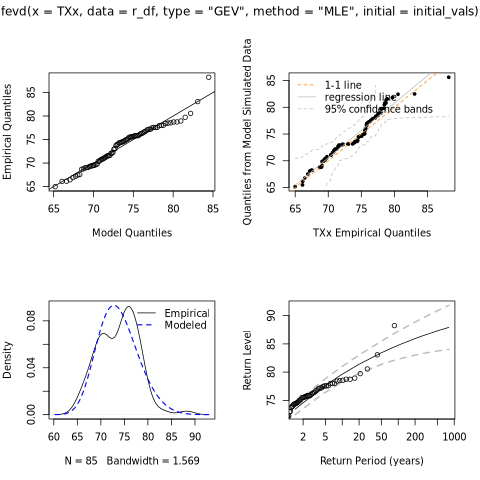

In [400]:
%R initial_vals <- list(location = mean(r_df[['TXx']]), scale = sd(r_df[['TXx']]), shape = 0.1)
%R fitGEV_FG <- fevd(TXx, data = r_df,type='GEV',method='MLE', initial = initial_vals)
%R fitGumb_FG <- fevd(TXx, data = r_df,type='Gumbel',method='MLE', initial = initial_vals) # Gumbel shape=0
print('#################')
print('GEV + First Guess')
print('#################')
%R pp <- summary(fitGEV_FG)
%R locGEV_FG <- pp[['par']][['location']]
%R scaleGEV_FG <- pp[['par']][['scale']]
%R shapeGEV_FG <- pp[['par']][['shape']]
%R plot(fitGEV_FG)
%R -o locGEV_FG,scaleGEV_FG,shapeGEV_FG

#################
Gumbel
#################

fevd(x = TXx, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  245.7293 


 Estimated parameters:
 location     scale 
71.648336  3.887579 

 Standard Error Estimates:
 location     scale 
0.4468037 0.3164820 

 Estimated parameter covariance matrix.
           location      scale
location 0.19963354 0.04676074
scale    0.04676074 0.10016086

 AIC = 495.4586 

 BIC = 500.3439 


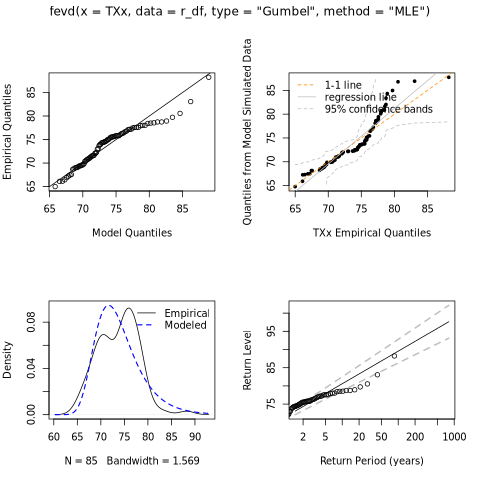

In [401]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [402]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGEV_FG<-return.level(fitGEV_FG, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGEV_FG,rlGumb


Text(0.5, 1.0, 'PT 6 (204$\\degree$E; 60$\\degree$N)')

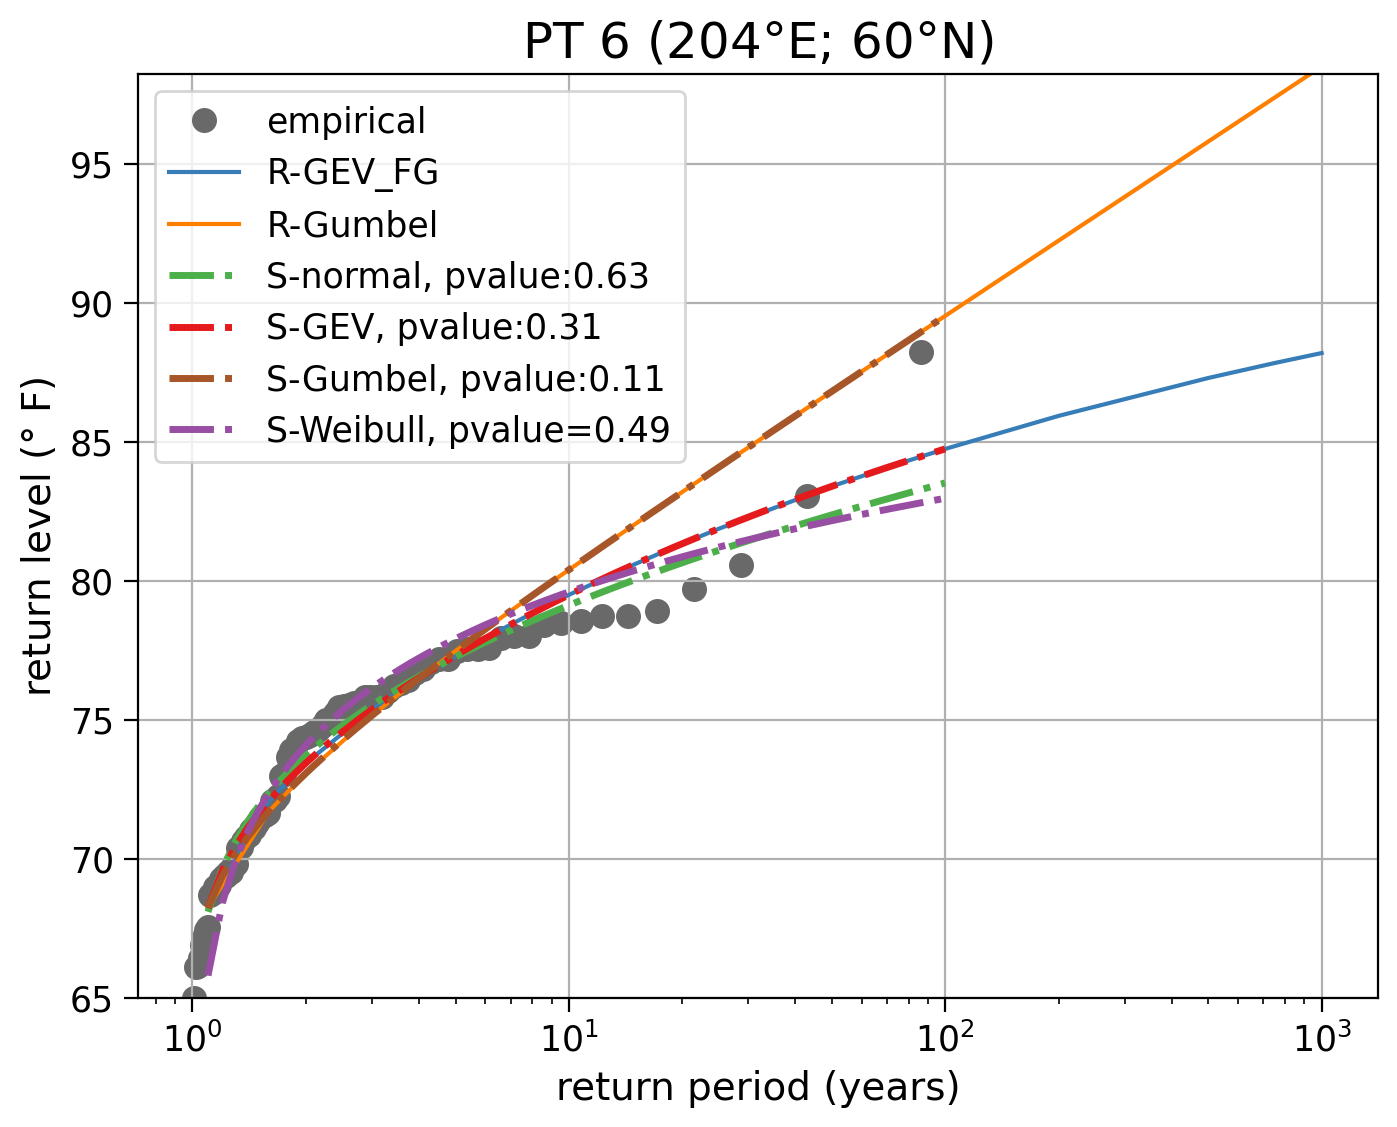

In [403]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(txx).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV_FG,c=CB_color[0],label='R-GEV_FG')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(txx,stats.norm.cdf, \
     args=(txx.mean(),txx.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=txx.mean(), scale=txx.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(txx,fc=0,loc=txx.mean(), scale=txx.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(txx, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(txx, floc=0, loc=txx.mean(), scale=txx.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(txx, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(txx.min(),txx.max()+10.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 6 (204$\\degree$E;60$\\degree$N)')

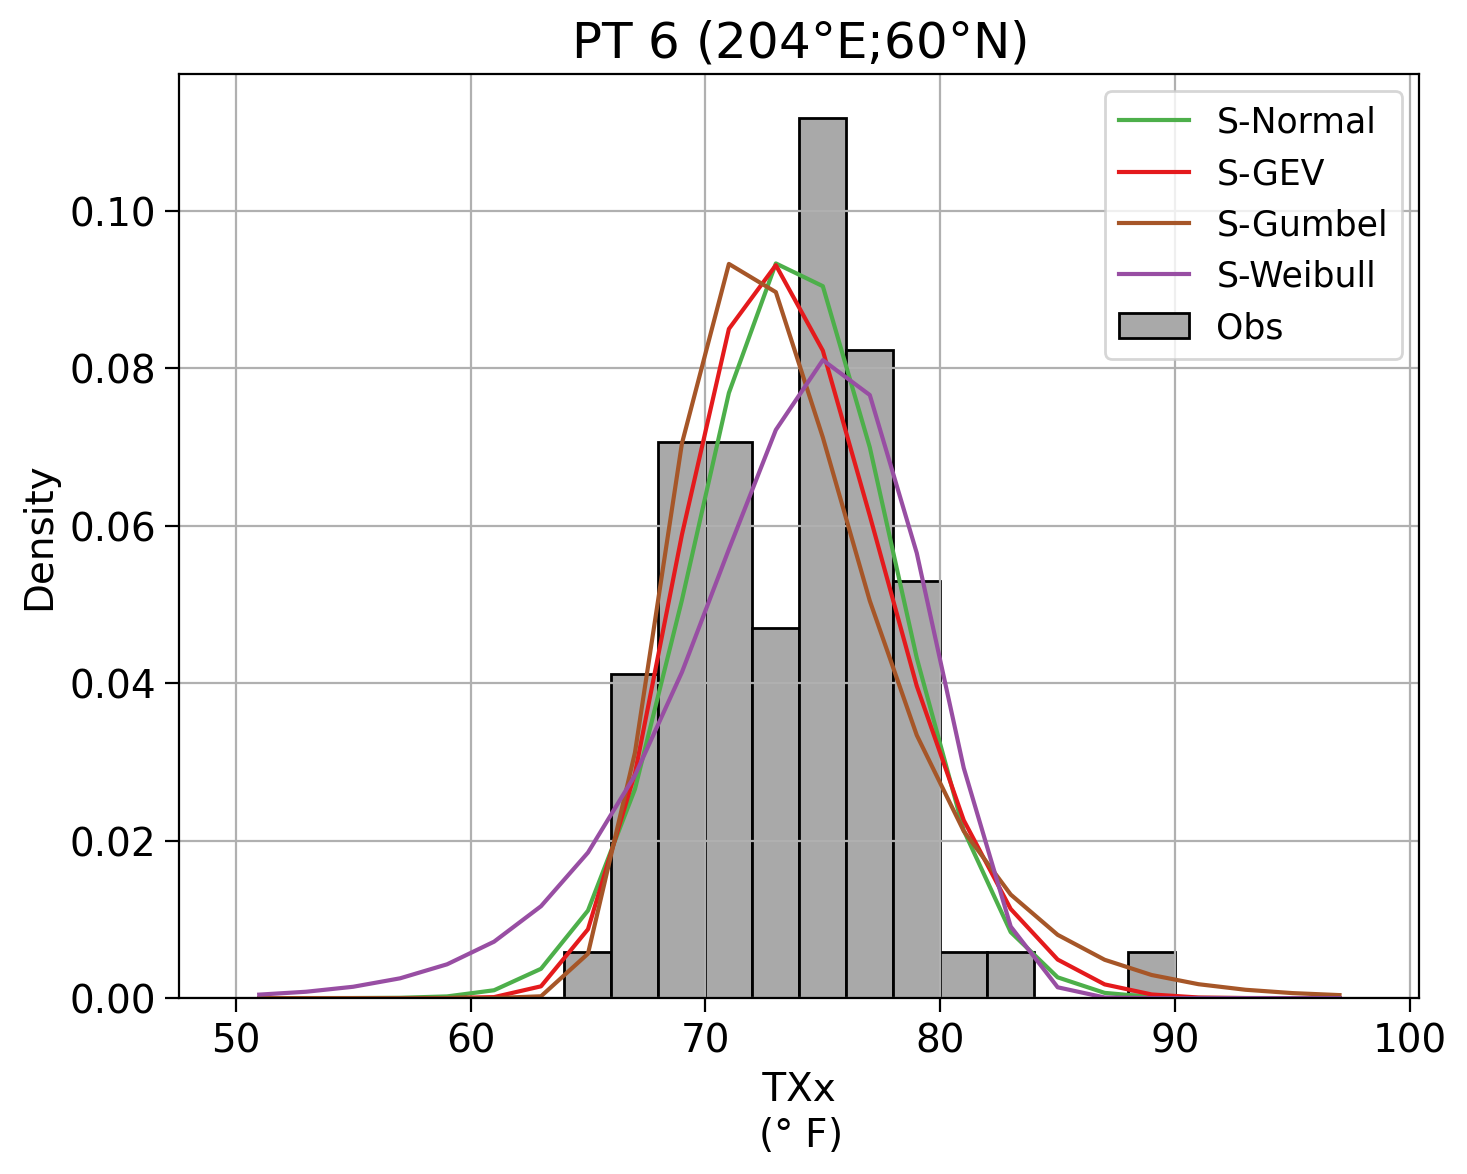

In [404]:
####
##### PDF Plot
#####

bins = np.arange(50,100,2)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(txx, bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=txx.mean(), scale=txx.std()),
    c=CB_color[2],lw=1.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=1.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=1.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=1.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(txx,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" TXx \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 7 
# Point in Maine

In [405]:

ij = 6
ilon=ptlon[ij]
ilat=ptlat[ij]
txx=ds['TXx'].sel(lon=ilon,lat=ilat).load()

df = txx.to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      TXx             year     
 Min.   :76.85   Min.   :1941  
 1st Qu.:81.23   1st Qu.:1962  
 Median :82.64   Median :1983  
 Mean   :82.73   Mean   :1983  
 3rd Qu.:84.65   3rd Qu.:2004  
 Max.   :89.18   Max.   :2025  



In [406]:
%R fitGEV <- fevd(TXx, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(TXx, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R -o locGEV,scaleGEV,shapeGEV

#################
GEV
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  200.7469 


 Estimated parameters:
  location      scale      shape 
81.7661866  2.4982976 -0.2348981 

 Standard Error Estimates:
  location      scale      shape 
0.30106095 0.21228819 0.07393822 

 Estimated parameter covariance matrix.
             location        scale        shape
location  0.090637698  0.005998737 -0.008650969
scale     0.005998737  0.045066275 -0.008409218
shape    -0.008650969 -0.008409218  0.005466861

 AIC = 407.4938 

 BIC = 414.8218 


#################
GEV + First Guess
#################

fevd(x = TXx, data = r_df, type = "GEV", method = "MLE", initial = initial_vals)

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  200.7469 


 Estimated parameters:
  location      scale      shape 
81.7661863  2.4982961 -0.2348973 

 Standard Error Estimates:
  location      scale      shape 
0.30106085 0.21228777 0.07393834 

 Estimated parameter covariance matrix.
             location        scale        shape
location  0.090637637  0.005998801 -0.008650992
scale     0.005998801  0.045066099 -0.008409175
shape    -0.008650992 -0.008409175  0.005466878

 AIC = 407.4938 

 BIC = 414.8218 


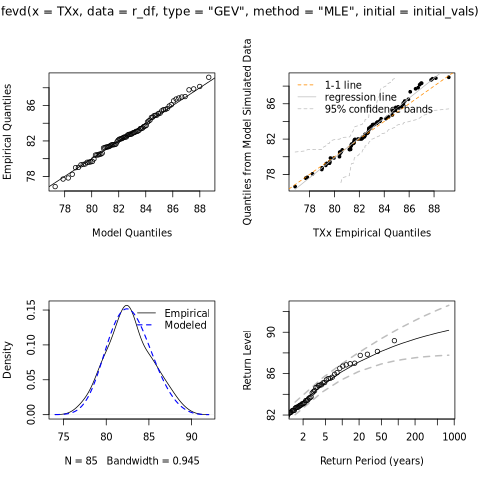

In [407]:
%R initial_vals <- list(location = mean(r_df[['TXx']]), scale = sd(r_df[['TXx']]), shape = 0.1)
%R fitGEV_FG <- fevd(TXx, data = r_df,type='GEV',method='MLE', initial = initial_vals)
print('#################')
print('GEV + First Guess')
print('#################')
%R pp <- summary(fitGEV_FG)
%R locGEV_FG <- pp[['par']][['location']]
%R scaleGEV_FG <- pp[['par']][['scale']]
%R shapeGEV_FG <- pp[['par']][['shape']]
%R plot(fitGEV_FG)
%R -o locGEV_FG,scaleGEV_FG,shapeGEV_FG

#################
Gumbel
#################

fevd(x = TXx, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  204.5889 


 Estimated parameters:
 location     scale 
81.461911  2.410026 

 Standard Error Estimates:
 location     scale 
0.2768931 0.1931665 

 Estimated parameter covariance matrix.
           location      scale
location 0.07666981 0.01763821
scale    0.01763821 0.03731328

 AIC = 413.1778 

 BIC = 418.0631 


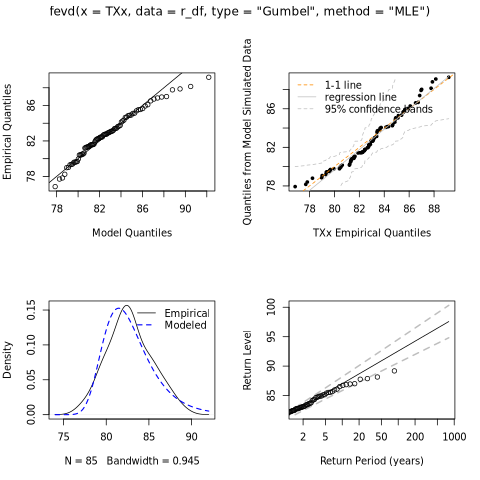

In [408]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [409]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGEV_FG<-return.level(fitGEV_FG, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGEV_FG,rlGumb

Text(0.5, 1.0, 'PT 7 (289$\\degree$E; 45$\\degree$N)')

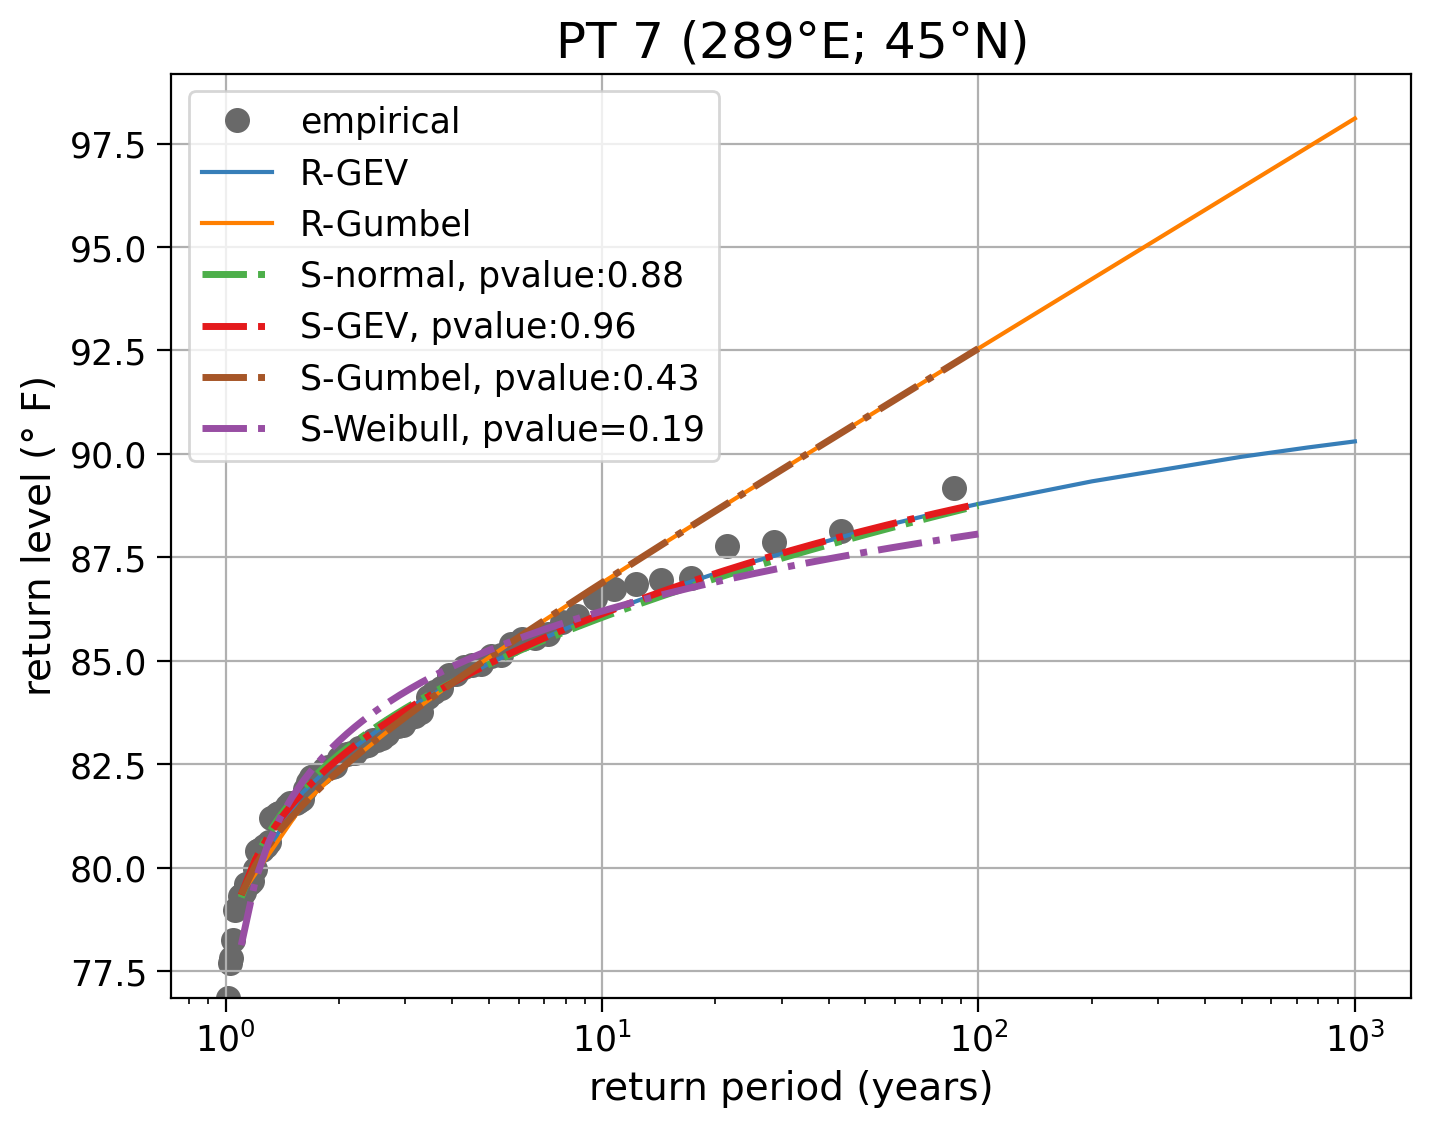

In [410]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(txx).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(txx,stats.norm.cdf, \
     args=(txx.mean(),txx.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=txx.mean(), scale=txx.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(txx, method="MLE", loc=txx.mean(), scale=txx.std(), )
pv_g= np.round(stats.kstest(txx, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(txx,fc=0,loc=txx.mean(), scale=txx.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(txx, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(txx, floc=0, loc=txx.mean(), scale=txx.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(txx, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(txx.min(),txx.max()+10.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 7 (289$\\degree$E;45$\\degree$N)')

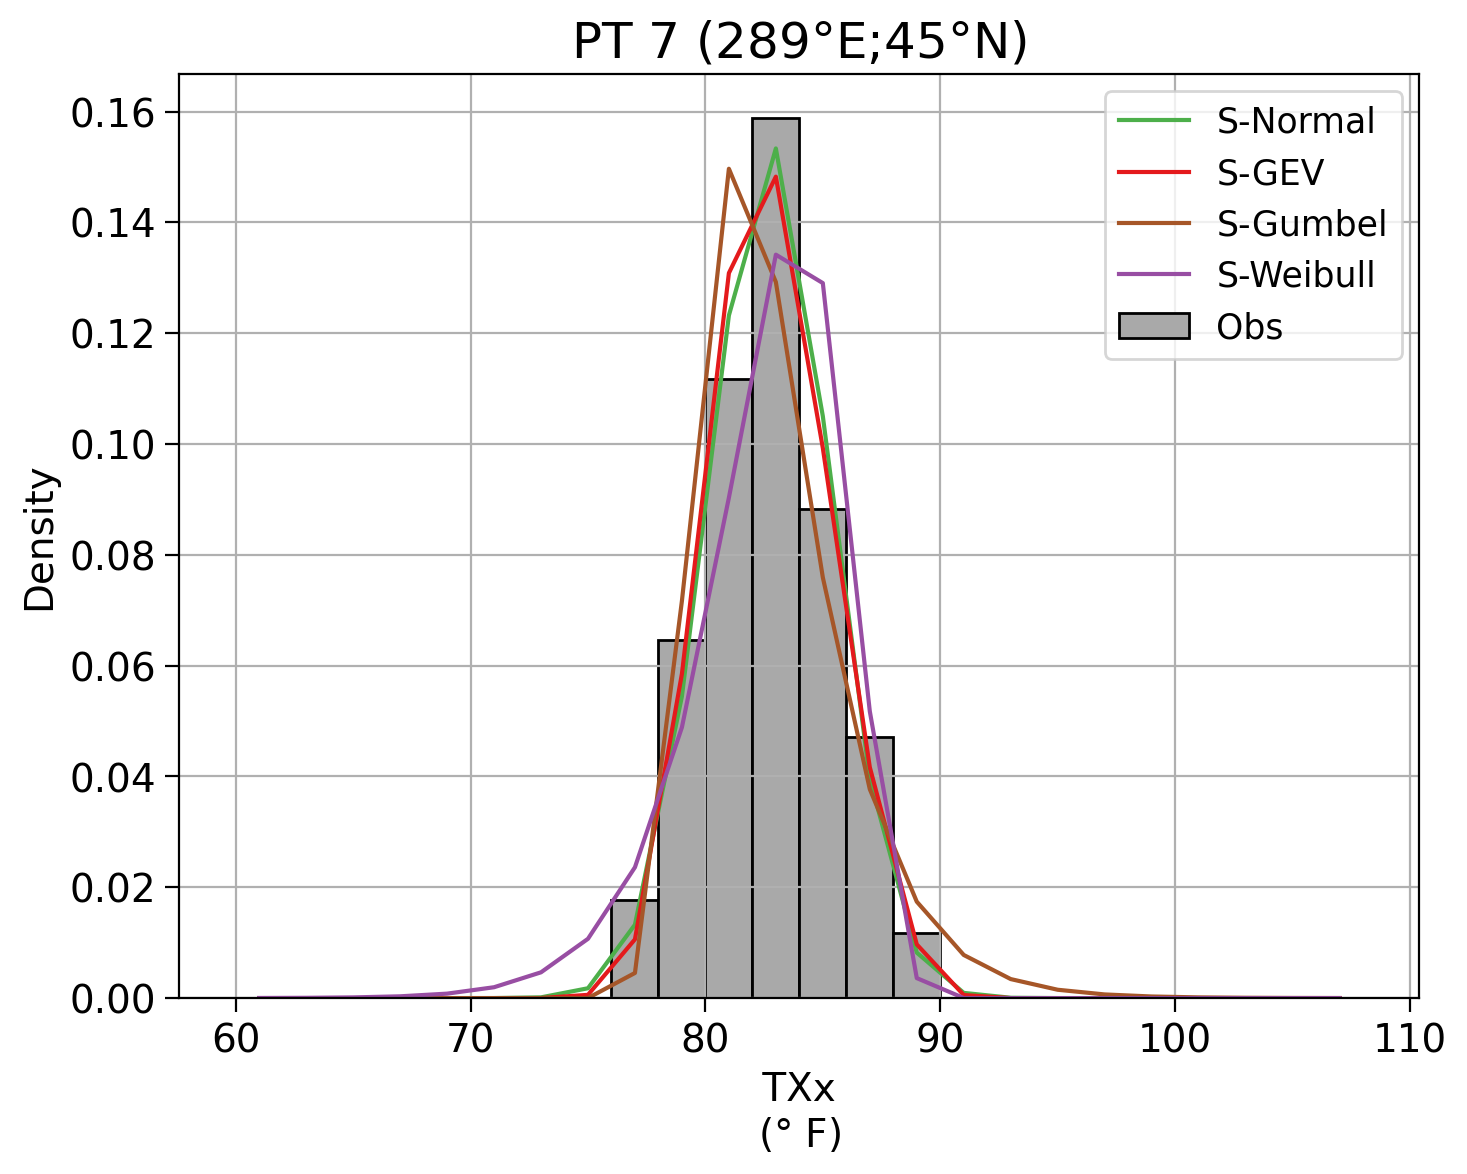

In [411]:
####
##### PDF Plot
#####

bins = np.arange(60,110,2)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(txx, bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=txx.mean(), scale=txx.std()),
    c=CB_color[2],lw=1.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=1.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=1.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=1.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(txx,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" TXx \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')